In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))  # add project root

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score

pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
plt.style.use("seaborn-v0_8-whitegrid")

from pipelines.pipeline_runner import run_full_pipeline_with_split  
from utils.ml_utils import prepare_X_y  
from utils.stage3_utils import (
    fit_stage3,
    transform_stage3,
    prepare_X_y
)




In [2]:
df=pd.read_csv("../data/raw/raw_dataset_v4.csv")  # Load dataset

In [3]:
# Run leakage-safe pipeline with Stage0 → Stage1 → Stage2 → split → Stage3Fitter
dfs = run_full_pipeline_with_split()

df_stage1 = dfs["stage1"]
df_stage2 = dfs["stage2"]

df_train = dfs["train"]
df_val   = dfs["val"]
df_test  = dfs["test"]



Running Stage 1...
Running Stage 2...
Running Stage 2.5 (Geo Enrichment)...
Saving intermediate files...
Splitting data...
Running Stage 3 (Fitted)...
Pipeline complete.


In [4]:
def evaluate_regression(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    print(f"===== {name} =====")
    print(f"MAE: {mae:,.2f}")
    print(f"R² : {r2:.4f}")
    return mae, r2


def plot_regression_diagnostics(y_true, y_pred, title_prefix="Model"):
    residuals = y_true - y_pred

    fig, axes = plt.subplots(1, 3, figsize=(22, 6))

    # 1) Actual vs Predicted
    axes[0].scatter(y_true, y_pred, alpha=0.4)
    min_v = min(y_true.min(), y_pred.min())
    max_v = max(y_true.max(), y_pred.max())
    axes[0].plot([min_v, max_v], [min_v, max_v], "r--", linewidth=2)
    axes[0].set_title(f"{title_prefix} — Actual vs Predicted")
    axes[0].set_xlabel("Actual Price")
    axes[0].set_ylabel("Predicted Price")

    # 2) Residual Distribution
    sns.histplot(residuals, kde=True, bins=40, ax=axes[1], color="steelblue")
    axes[1].set_title(f"{title_prefix} — Residual Distribution")
    axes[1].set_xlabel("Residual (Actual - Predicted)")

    # 3) Residuals vs Predicted
    axes[2].scatter(y_pred, residuals, alpha=0.4)
    axes[2].axhline(0, color="red", linestyle="--", linewidth=2)
    axes[2].set_title(f"{title_prefix} — Residuals vs Predicted")
    axes[2].set_xlabel("Predicted Price")
    axes[2].set_ylabel("Residual")

    plt.tight_layout()
    plt.show()


def plot_lr_feature_importance(model, feature_names, top_n=20, title="LR Coefficients"):
    """
    model: fitted LinearRegression (from pipeline.named_steps["model"])
    feature_names: list/Index of feature names (X.columns)
    """
    coefs = model.coef_
    features = np.array(feature_names)

    idx = np.argsort(np.abs(coefs))[::-1][:top_n]
    top_features = features[idx]
    top_coefs = coefs[idx]

    plt.figure(figsize=(10, 6))
    y_pos = np.arange(len(top_features))
    plt.barh(y_pos, top_coefs)
    plt.yticks(y_pos, top_features)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Coefficient value")
    plt.tight_layout()
    plt.show()


def plot_tree_importances(model, feature_names, top_n=30, title="Random Forest — Feature Importances"):
    importances = model.feature_importances_
    features = np.array(feature_names)
    idx = np.argsort(importances)[::-1][:top_n]
    top_features = features[idx]
    top_importances = importances[idx]

    plt.figure(figsize=(12, 10))
    y_pos = np.arange(len(top_features))
    plt.barh(y_pos, top_importances)
    plt.yticks(y_pos, top_features)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()



--- XGBoost (Train) ---
===== XGBoost — Train =====
MAE: 34,947.04
R² : 0.9549

--- XGBoost (Validation) ---
===== XGBoost — Validation =====
MAE: 52,522.43
R² : 0.8722

--- XGBoost (Test) ---
===== XGBoost — Test =====
MAE: 54,090.90
R² : 0.8071


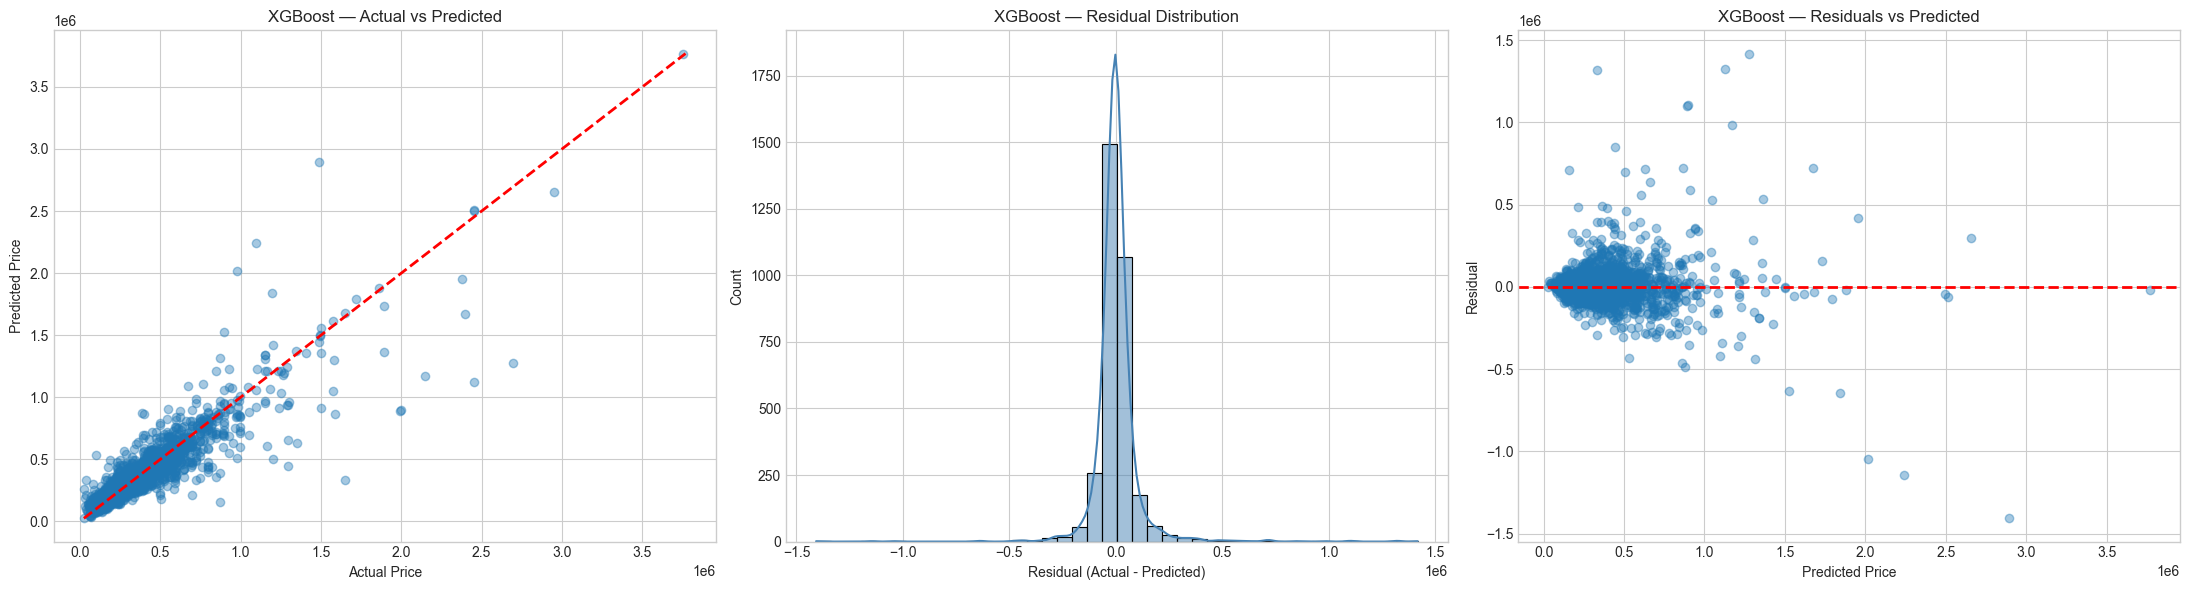

In [ ]:
#Values of 01/12/2025
# 
# # ============================================================
# XGBOOST REGRESSOR — TRAIN / VAL / TEST (BEST OPTUNA PARAMS)
# ============================================================

from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Build X, y (tree-based → use model_type="rf")
X_train_xgb, y_train_xgb = prepare_X_y(df_train, model_type="rf")
X_val_xgb,   y_val_xgb   = prepare_X_y(df_val,   model_type="rf")
X_test_xgb,  y_test_xgb  = prepare_X_y(df_test,  model_type="rf")

# Pipeline: Imputer + XGBoost
xgb_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", XGBRegressor(
            n_estimators=1461,
            max_depth=5,
            learning_rate=0.029967005336314093,
            subsample=0.6644029679905439,
            colsample_bytree=0.9849185407368451,
            min_child_weight=7,
            reg_alpha=5.568504603848263,
            reg_lambda=5.213493163319067,
            
            # static params
            random_state=42,
            n_jobs=-1,
            objective="reg:squarederror"
        ))
    ]
)

# Fit
xgb_pipeline.fit(X_train_xgb, y_train_xgb)

# Predict
y_pred_train_xgb = xgb_pipeline.predict(X_train_xgb)
y_pred_val_xgb   = xgb_pipeline.predict(X_val_xgb)
y_pred_test_xgb  = xgb_pipeline.predict(X_test_xgb)

# Evaluate
print("\n--- XGBoost (Train) ---")
evaluate_regression("XGBoost — Train", y_train_xgb, y_pred_train_xgb)

print("\n--- XGBoost (Validation) ---")
evaluate_regression("XGBoost — Validation", y_val_xgb, y_pred_val_xgb)

print("\n--- XGBoost (Test) ---")
evaluate_regression("XGBoost — Test", y_test_xgb, y_pred_test_xgb)

# Diagnostics on TEST
plot_regression_diagnostics(y_test_xgb, y_pred_test_xgb, title_prefix="XGBoost")



   5-FOLD CROSS-VALIDATION

--- Fold 1 ---
 Train R²: 0.95948 | MAE: 34,094
 Valid R²: 0.83272 | MAE: 50,640

--- Fold 2 ---
 Train R²: 0.95808 | MAE: 33,695
 Valid R²: 0.82719 | MAE: 51,591

--- Fold 3 ---
 Train R²: 0.95540 | MAE: 33,711
 Valid R²: 0.84138 | MAE: 55,405

--- Fold 4 ---
 Train R²: 0.95707 | MAE: 33,619
 Valid R²: 0.77420 | MAE: 54,870

--- Fold 5 ---
 Train R²: 0.95935 | MAE: 34,129
 Valid R²: 0.86922 | MAE: 49,415

 CROSS-VALIDATION SUMMARY (5 FOLDS)

Mean Train R²: 0.95787
Mean Valid R²: 0.82894
Mean Train MAE: 33,850
Mean Valid MAE: 52,384

 TRAIN FINAL MODEL ON FULL TRAIN SET


--- FINAL MODEL PERFORMANCE ---
===== Final XGB — Train =====
MAE: 35,081.36
R² : 0.9544
===== Final XGB — Validation =====
MAE: 52,112.20
R² : 0.8726
===== Final XGB — Test =====
MAE: 54,318.66
R² : 0.8018


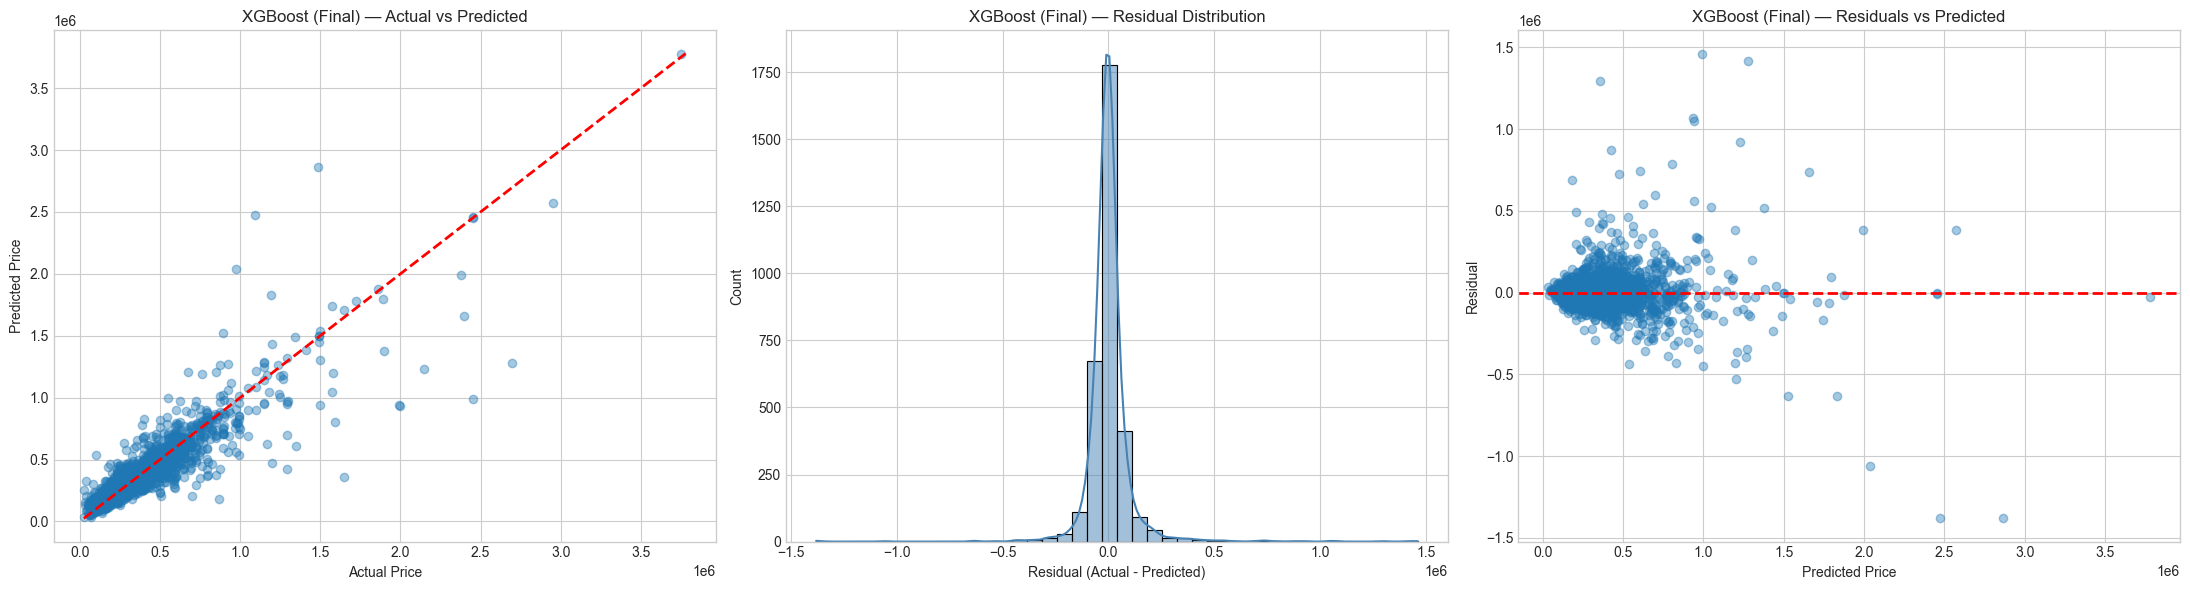

In [11]:
# ============================================================
# XGBOOST REGRESSOR — 5-FOLD CROSS-VALIDATION (BEST OPTUNA PARAMS)
# Values of 01/12/2025
# ============================================================

from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

# -----------------------------------------
# Prepare data
# -----------------------------------------
X_train_xgb, y_train_xgb = prepare_X_y(df_train, model_type="rf")
X_val_xgb,   y_val_xgb   = prepare_X_y(df_val,   model_type="rf")
X_test_xgb,  y_test_xgb  = prepare_X_y(df_test,  model_type="rf")

# -----------------------------------------
# Best parameters from Optuna (01/12/2025)
# -----------------------------------------
best_params = {
    "n_estimators": 1461,
    "max_depth": 5,
    "learning_rate": 0.029967005336314093,
    "subsample": 0.6644029679905439,
    "colsample_bytree": 0.9849185407368451,
    "min_child_weight": 7,
    "reg_alpha": 5.568504603848263,
    "reg_lambda": 5.213493163319067,

    # static
    "random_state": 42,
    "n_jobs": -1,
    "objective": "reg:squarederror",
}

# -----------------------------------------
# Pipeline: Imputer + XGBRegressor
# -----------------------------------------
pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", XGBRegressor(**best_params)),
    ]
)

# -----------------------------------------
# 5-FOLD CV
# -----------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_results = {
    "train_r2": [],
    "val_r2": [],
    "train_mae": [],
    "val_mae": [],
}

print("\n==========================")
print("   5-FOLD CROSS-VALIDATION")
print("==========================\n")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_xgb), start=1):
    X_tr, X_va = X_train_xgb.iloc[train_idx], X_train_xgb.iloc[val_idx]
    y_tr, y_va = y_train_xgb.iloc[train_idx], y_train_xgb.iloc[val_idx]

    # Fit on fold
    pipeline.fit(X_tr, y_tr)

    # Predict
    pred_tr = pipeline.predict(X_tr)
    pred_va = pipeline.predict(X_va)

    # Metrics
    r2_tr = r2_score(y_tr, pred_tr)
    r2_va = r2_score(y_va, pred_va)
    mae_tr = mean_absolute_error(y_tr, pred_tr)
    mae_va = mean_absolute_error(y_va, pred_va)

    fold_results["train_r2"].append(r2_tr)
    fold_results["val_r2"].append(r2_va)
    fold_results["train_mae"].append(mae_tr)
    fold_results["val_mae"].append(mae_va)

    print(f"--- Fold {fold} ---")
    print(f" Train R²: {r2_tr:.5f} | MAE: {mae_tr:,.0f}")
    print(f" Valid R²: {r2_va:.5f} | MAE: {mae_va:,.0f}")
    print()

# -----------------------------------------
# MEAN CV RESULTS
# -----------------------------------------
print("===========================================================")
print(" CROSS-VALIDATION SUMMARY (5 FOLDS)")
print("===========================================================\n")

print(f"Mean Train R²: {np.mean(fold_results['train_r2']):.5f}")
print(f"Mean Valid R²: {np.mean(fold_results['val_r2']):.5f}")
print(f"Mean Train MAE: {np.mean(fold_results['train_mae']):,.0f}")
print(f"Mean Valid MAE: {np.mean(fold_results['val_mae']):,.0f}\n")

# -----------------------------------------
# FINAL MODEL — TRAIN ON FULL TRAIN + VAL
# -----------------------------------------
print("===========================================================")
print(" TRAIN FINAL MODEL ON FULL TRAIN SET")
print("===========================================================\n")

pipeline.fit(X_train_xgb, y_train_xgb)

y_pred_train_final = pipeline.predict(X_train_xgb)
y_pred_val_final   = pipeline.predict(X_val_xgb)
y_pred_test_final  = pipeline.predict(X_test_xgb)

print("\n--- FINAL MODEL PERFORMANCE ---")
evaluate_regression("Final XGB — Train", y_train_xgb, y_pred_train_final)
evaluate_regression("Final XGB — Validation", y_val_xgb, y_pred_val_final)
evaluate_regression("Final XGB — Test", y_test_xgb, y_pred_test_final)

# Diagnostics (Test Set)
plot_regression_diagnostics(y_test_xgb, y_pred_test_final, title_prefix="XGBoost (Final)")



--- XGBoost (Train) ---
===== XGBoost — Train =====
MAE: 11,777.68
R² : 0.9955

--- XGBoost (Validation) ---
===== XGBoost — Validation =====
MAE: 47,405.14
R² : 0.8716

--- XGBoost (Test) ---
===== XGBoost — Test =====
MAE: 48,819.36
R² : 0.8077


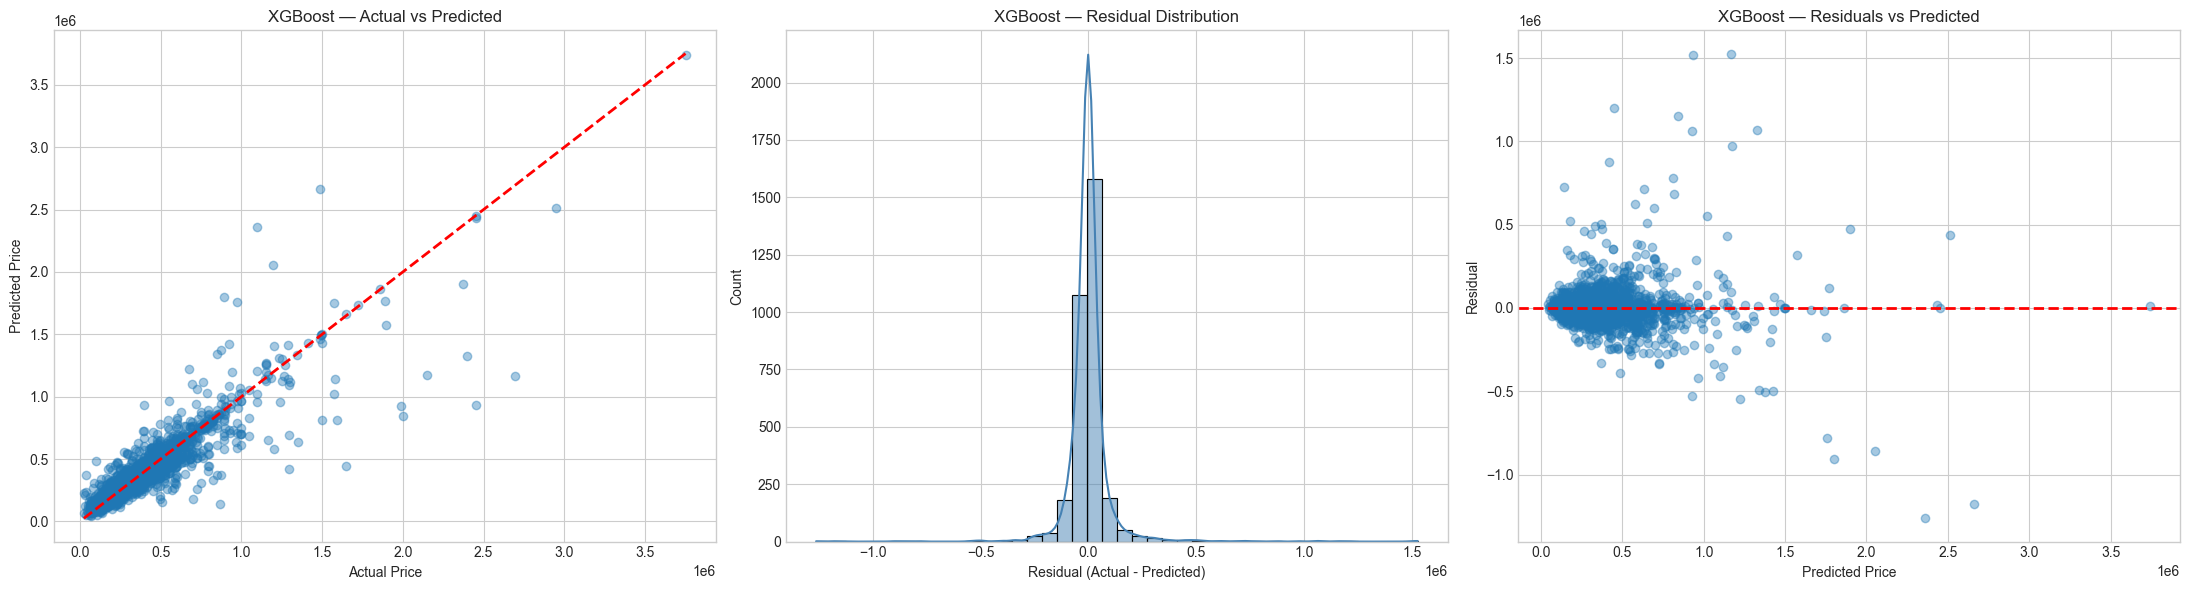

In [ ]:
# ============================================================
# XGBOOST REGRESSOR — TRAIN / VAL / TEST (BEST OPTUNA PARAMS)
# ============================================================

from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Build X, y (tree-based → use model_type="rf")
X_train_xgb, y_train_xgb = prepare_X_y(df_train, model_type="rf")
X_val_xgb,   y_val_xgb   = prepare_X_y(df_val,   model_type="rf")
X_test_xgb,  y_test_xgb  = prepare_X_y(df_test,  model_type="rf")

# Pipeline: Imputer + XGBoost
xgb_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", XGBRegressor(
            n_estimators=633,
            max_depth=7,
            learning_rate=0.10965559401564222,
            subsample=0.7333215338016489,
            colsample_bytree=0.7421811425930882,
            min_child_weight=5,
            reg_alpha=2.263953345864266,
            reg_lambda=1.3354730299277326,
            
            # static params
            random_state=42,
            n_jobs=-1,
            objective="reg:squarederror"
        ))
    ]
)

# Fit
xgb_pipeline.fit(X_train_xgb, y_train_xgb)

# Predict
y_pred_train_xgb = xgb_pipeline.predict(X_train_xgb)
y_pred_val_xgb   = xgb_pipeline.predict(X_val_xgb)
y_pred_test_xgb  = xgb_pipeline.predict(X_test_xgb)

# Evaluate
print("\n--- XGBoost (Train) ---")
evaluate_regression("XGBoost — Train", y_train_xgb, y_pred_train_xgb)

print("\n--- XGBoost (Validation) ---")
evaluate_regression("XGBoost — Validation", y_val_xgb, y_pred_val_xgb)

print("\n--- XGBoost (Test) ---")
evaluate_regression("XGBoost — Test", y_test_xgb, y_pred_test_xgb)

# Diagnostics on TEST
plot_regression_diagnostics(y_test_xgb, y_pred_test_xgb, title_prefix="XGBoost")



--- CatBoost (Train) ---
===== CatBoost — Train =====
MAE: 35,739.88
R² : 0.9605

--- CatBoost (Validation) ---
===== CatBoost — Validation =====
MAE: 52,611.67
R² : 0.8766

--- CatBoost (Test) ---
===== CatBoost — Test =====
MAE: 54,001.68
R² : 0.8162


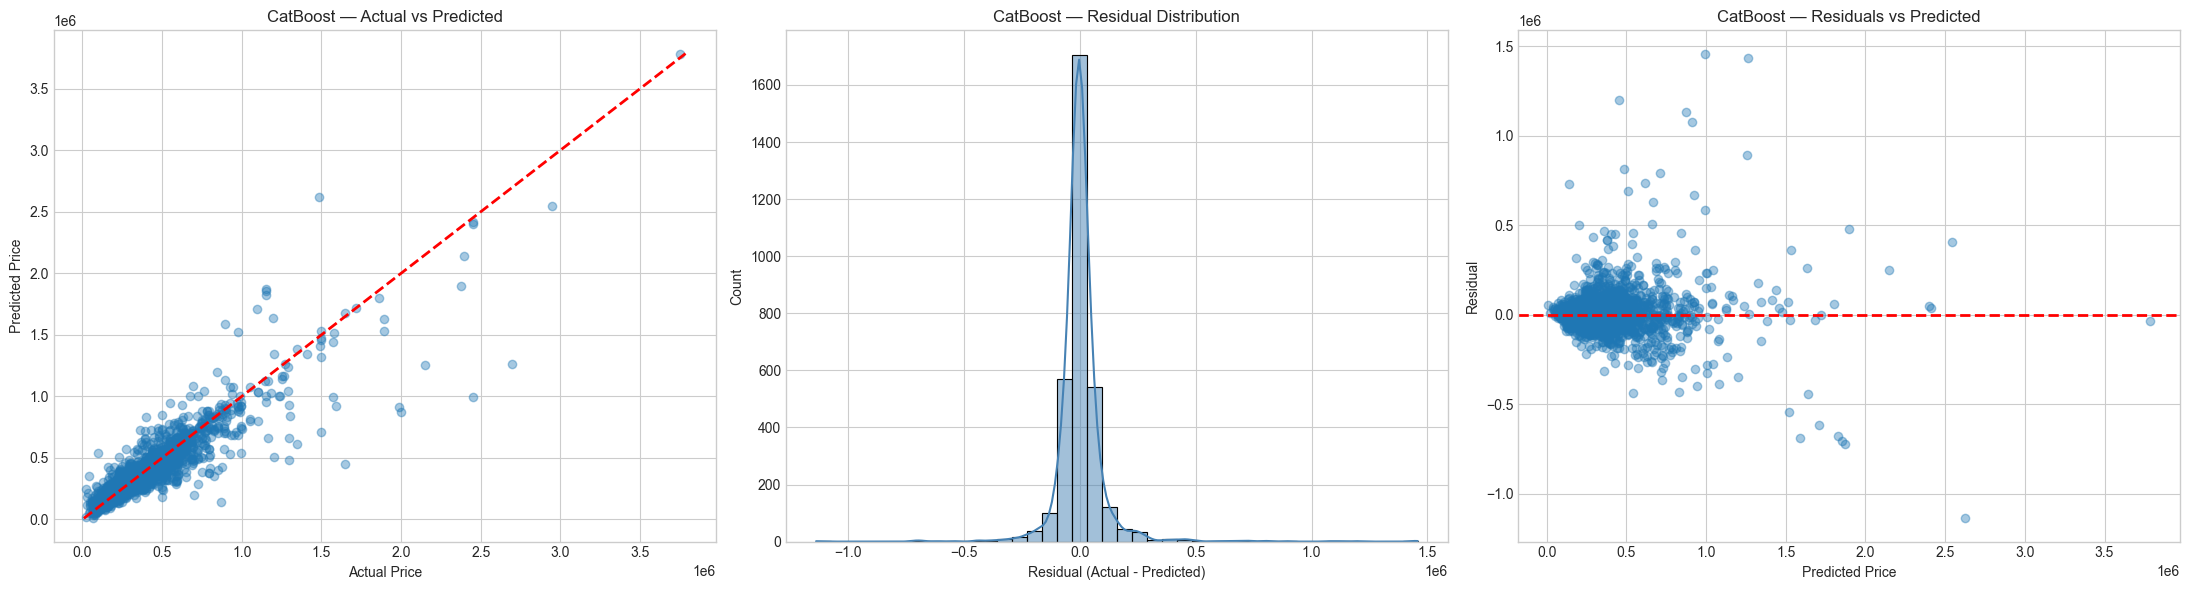

In [6]:
# ============================================================
# CATBOOST REGRESSOR — TRAIN / VAL / TEST (BEST OPTUNA PARAMS)
# ============================================================

from catboost import CatBoostRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Build X, y
X_train_cb, y_train_cb = prepare_X_y(df_train, model_type="rf")
X_val_cb,   y_val_cb   = prepare_X_y(df_val,   model_type="rf")
X_test_cb,  y_test_cb  = prepare_X_y(df_test,  model_type="rf")

# Pipeline: Imputer + CatBoost
cat_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", CatBoostRegressor(
            iterations=448,
            depth=6,
            learning_rate=0.14099952901923207,
            l2_leaf_reg=1.002272829607597,
            random_strength=3.6326372602347763,
            bagging_temperature=0.674212381904418,
            border_count=217,

            # Static parameters
            loss_function="RMSE",
            random_state=42,
            verbose=False,
            task_type="CPU"
        ))
    ]
)

# Fit
cat_pipeline.fit(X_train_cb, y_train_cb)

# Predict
y_pred_train_cb = cat_pipeline.predict(X_train_cb)
y_pred_val_cb   = cat_pipeline.predict(X_val_cb)
y_pred_test_cb  = cat_pipeline.predict(X_test_cb)

# Evaluate
print("\n--- CatBoost (Train) ---")
evaluate_regression("CatBoost — Train", y_train_cb, y_pred_train_cb)

print("\n--- CatBoost (Validation) ---")
evaluate_regression("CatBoost — Validation", y_val_cb, y_pred_val_cb)

print("\n--- CatBoost (Test) ---")
evaluate_regression("CatBoost — Test", y_test_cb, y_pred_test_cb)

# Diagnostics on TEST
plot_regression_diagnostics(y_test_cb, y_pred_test_cb, title_prefix="CatBoost")


## Split X and y

In [5]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

import xgboost as xgb
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

# ========================================
# CONFIG
# ========================================

DATA_PATH = "../data_for_kaggle.csv"
OUTPUT_DIR = "/kaggle/working/"

TEST_SIZE = 0.15
RANDOM_STATE = 42
N_TRIALS = 200      # reduced for speed; can increase
EARLY_STOPPING_ROUNDS = 50

TARGET_ENCODING_ALPHA = 100.0

# ========================================
# FEATURE ENGINEERING (SAME AS BEFORE)
# ========================================

MISSINGNESS_NUMERIC_COLS = [
    "area", "state", "facades_number", "is_furnished", "has_terrace", "has_garden",
    "has_swimming_pool", "has_equipped_kitchen", "build_year", "cellar",
    "has_garage", "bathrooms", "heating_type", "sewer_connection",
    "certification_electrical_installation", "preemption_right", "flooding_area_type",
    "leased", "living_room_surface", "attic_house", "glazing_type",
    "elevator", "access_disabled", "toilets", "cadastral_income_house",
]

LOG_FEATURES = ["area"]

TARGET_ENCODING_COLS = ["property_subtype", "property_type", "postal_code", "locality"]
TARGET_ENCODING_ALPHA = 100.0

GEO_COLUMNS = [
    "apt_avg_m2_province", "house_avg_m2_province",
    "apt_avg_m2_region", "house_avg_m2_region",
    "province_benchmark_m2", "region_benchmark_m2",
    "national_benchmark_m2"
]


def add_missingness_flags(df):
    df = df.copy()
    for col in MISSINGNESS_NUMERIC_COLS:
        if col in df.columns:
            df[f"{col}_missing"] = (df[col] == -1).astype(int)
    return df


def convert_minus1_to_nan(df):
    df = df.copy()
    for col in MISSINGNESS_NUMERIC_COLS:
        if col in df.columns:
            df[col] = df[col].replace(-1, np.nan)
    return df


def add_log_features(df):
    df = df.copy()
    for col in LOG_FEATURES:
        if col in df.columns:
            vals = df[col]
            mask = vals > 0
            out = np.full(len(df), np.nan)
            out[mask] = np.log1p(vals[mask])
            df[f"{col}_log"] = out
    return df


def impute_features(df, numeric_medians, ordinal_modes):
    df = df.copy()

    # Numeric
    for col, med in numeric_medians.items():
        if col in df.columns:
            df[col] = df[col].fillna(med)

    # Binary
    binary_cols = [
        "cellar", "has_garage", "has_swimming_pool", "has_equipped_kitchen",
        "access_disabled", "elevator", "leased", "is_furnished",
        "has_terrace", "has_garden"
    ]
    for col in binary_cols:
        if col in df.columns:
            df[col] = df[col].fillna(0)

    # Ordinal
    for col, mode in ordinal_modes.items():
        if col in df.columns:
            df[col] = df[col].fillna(mode)

    return df


def fit_stage3(df_train):
    df = df_train.copy()
    df = add_missingness_flags(df)
    df = convert_minus1_to_nan(df)

    numeric_cont = [
        "area", "rooms", "living_room_surface", "build_year",
        "facades_number", "bathrooms", "toilets",
        "cadastral_income_house", "median_income"
    ]

    ordinal_cols = [
        "heating_type", "glazing_type", "sewer_connection",
        "certification_electrical_installation", "preemption_right",
        "flooding_area_type", "attic_house", "state",
        "region", "province"
    ]

    numeric_medians = {}
    for col in numeric_cont:
        if col in df.columns:
            numeric_medians[col] = df[col].median()

    ordinal_modes = {}
    for col in ordinal_cols:
        if col in df.columns:
            mode = df[col].mode(dropna=True)
            ordinal_modes[col] = mode.iloc[0] if len(mode) else 0

    df = impute_features(df, numeric_medians, ordinal_modes)
    df = add_log_features(df)

    te_maps = {}
    global_means = {}

    for col in TARGET_ENCODING_COLS:
        if col in df.columns:
            global_mean = df["price"].mean()
            stats = df.groupby(col)["price"].agg(["mean", "count"])
            smoothed = (
                (stats["count"] * stats["mean"] + TARGET_ENCODING_ALPHA * global_mean)
                / (stats["count"] + TARGET_ENCODING_ALPHA)
            )
            te_maps[col] = smoothed.to_dict()
            global_means[col] = global_mean

    if "area_log" in df.columns:
        numeric_medians["area_log"] = df["area_log"].median()

    return {
        "numeric_medians": numeric_medians,
        "ordinal_modes": ordinal_modes,
        "te_maps": te_maps,
        "global_means": global_means,
    }


def transform_stage3(df, fitted):
    df = df.copy()
    df = add_missingness_flags(df)
    df = convert_minus1_to_nan(df)

    # backup geo fields
    geo_backup = {col: df[col].copy() for col in GEO_COLUMNS if col in df.columns}

    df = impute_features(df, fitted["numeric_medians"], fitted["ordinal_modes"])

    # restore geo fields
    for col, vals in geo_backup.items():
        df[col] = vals

    df = add_log_features(df)

    for col, mapping in fitted["te_maps"].items():
        if col in df.columns:
            df[f"{col}_te_price"] = df[col].map(mapping).fillna(fitted["global_means"][col])

    df = impute_features(df, fitted["numeric_medians"], fitted["ordinal_modes"])

    # restore geo again
    for col, vals in geo_backup.items():
        df[col] = vals

    return df


def prepare_X_y(df):
    df = df.copy()

    drop_cols = ["property_id", "url", "address"]
    drop_cols += [c for c in df.columns if c.startswith("__stage")]
    df = df.drop(columns=drop_cols, errors="ignore")

    y = df["price"]
    X = df.drop(columns=["price"], errors="ignore")

    leakage_cols = ["price_log"]
    leakage_cols += [c for c in X.columns if c.startswith("diff_to_") or c.startswith("ratio_to_")]
    X = X.drop(columns=leakage_cols, errors="ignore")

    X = X.select_dtypes(include=[np.number])

    X = X.drop(columns=[c for c in X.columns if c.endswith("_log")], errors="ignore")

    return X, y

In [11]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

import xgboost as xgb
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

df=pd.read_csv(DATA_PATH)
X_train, y_train = prepare_X_y(df)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
xgb_scores = []

for train_index, val_index in kf.split(X_train):

    X_tr, X_va = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_va = y_train.iloc[train_index], y_train.iloc[val_index]

    model = XGBRegressor(
        n_estimators=1461,
        max_depth=5,
        learning_rate=0.029967005336314093,
        subsample=0.6644029679905439,
        colsample_bytree=0.9849185407368451,
        min_child_weight=7,
        reg_alpha=5.568504603848263,
        reg_lambda=5.213493163319067,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_tr, y_tr)

    # Train predictions
    preds_train = model.predict(X_tr)
    r2_train = r2_score(y_tr, preds_train)
    mae_train = mean_absolute_error(y_tr, preds_train)

    # Validation predictions
    preds_val = model.predict(X_va)
    r2_val = r2_score(y_va, preds_val)
    mae_val = mean_absolute_error(y_va, preds_val)

    xgb_scores.append((r2_train, mae_train, r2_val, mae_val))

    print(
        f"XGB Fold {fold} → "
        f"Train R2: {r2_train:.5f} | Train MAE: {mae_train:.2f} || "
        f"Val R2: {r2_val:.5f} | Val MAE: {mae_val:.2f}"
    )

    fold += 1


# Summary
mean_r2_train = np.mean([s[0] for s in xgb_scores])
mean_mae_train = np.mean([s[1] for s in xgb_scores])
mean_r2_val   = np.mean([s[2] for s in xgb_scores])
mean_mae_val  = np.mean([s[3] for s in xgb_scores])

print("\n=== XGBOOST 5-FOLD CV SUMMARY ===")
print(f"Mean Train R2: {mean_r2_train:.5f}")
print(f"Mean Train MAE: {mean_mae_train:.2f}")
print(f"Mean Val   R2: {mean_r2_val:.5f}")
print(f"Mean Val   MAE: {mean_mae_val:.2f}")


XGB Fold 1 → Train R2: 0.94712 | Train MAE: 37256.54 || Val R2: 0.83799 | Val MAE: 54644.32
XGB Fold 2 → Train R2: 0.94486 | Train MAE: 38153.42 || Val R2: 0.83876 | Val MAE: 51549.50
XGB Fold 3 → Train R2: 0.94544 | Train MAE: 37632.45 || Val R2: 0.84068 | Val MAE: 52722.26
XGB Fold 4 → Train R2: 0.94758 | Train MAE: 37153.73 || Val R2: 0.81291 | Val MAE: 53505.25
XGB Fold 5 → Train R2: 0.94642 | Train MAE: 37562.49 || Val R2: 0.83712 | Val MAE: 53061.36

=== XGBOOST 5-FOLD CV SUMMARY ===
Mean Train R2: 0.94628
Mean Train MAE: 37551.73
Mean Val   R2: 0.83349
Mean Val   MAE: 53096.54


In [ ]:
# Test new sequence from script

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

# ========================================
# CONFIG
# ========================================

DATA_PATH = "../data_for_kaggle.csv"
OUTPUT_DIR = "/kaggle/working/"

TEST_SIZE = 0.15
RANDOM_STATE = 42
N_TRIALS = 200      # reduced for speed; can increase
EARLY_STOPPING_ROUNDS = 50

TARGET_ENCODING_ALPHA = 100.0


# 1) Load raw data
df = pd.read_csv(DATA_PATH)

# 2) Split BEFORE Stage 3
df_train, df_test = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# 3) Fit Stage 3 ONLY on training
fitted = fit_stage3(df_train)

# 4) Transform BOTH datasets using training stats
df_train_s3 = transform_stage3(df_train, fitted)
df_test_s3  = transform_stage3(df_test, fitted)

# 5) Final X and y
X_train, y_train = prepare_X_y(df_train_s3)
X_test,  y_test  = prepare_X_y(df_test_s3)


kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
xgb_scores = []

for train_index, val_index in kf.split(X_train):

    X_tr, X_va = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_va = y_train.iloc[train_index], y_train.iloc[val_index]

    model = XGBRegressor(
        n_estimators=1461,
        max_depth=5,
        learning_rate=0.029967005336314093,
        subsample=0.6644029679905439,
        colsample_bytree=0.9849185407368451,
        min_child_weight=7,
        reg_alpha=5.568504603848263,
        reg_lambda=5.213493163319067,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_tr, y_tr)

    # Train predictions
    preds_train = model.predict(X_tr)
    r2_train = r2_score(y_tr, preds_train)
    mae_train = mean_absolute_error(y_tr, preds_train)

    # Validation predictions
    preds_val = model.predict(X_va)
    r2_val = r2_score(y_va, preds_val)
    mae_val = mean_absolute_error(y_va, preds_val)

    xgb_scores.append((r2_train, mae_train, r2_val, mae_val))

    print(
        f"XGB Fold {fold} → "
        f"Train R2: {r2_train:.5f} | Train MAE: {mae_train:.2f} || "
        f"Val R2: {r2_val:.5f} | Val MAE: {mae_val:.2f}"
    )

    fold += 1


# Summary
mean_r2_train = np.mean([s[0] for s in xgb_scores])
mean_mae_train = np.mean([s[1] for s in xgb_scores])
mean_r2_val   = np.mean([s[2] for s in xgb_scores])
mean_mae_val  = np.mean([s[3] for s in xgb_scores])

print("\n=== XGBOOST 5-FOLD CV SUMMARY ===")
print(f"Mean Train R2: {mean_r2_train:.5f}")
print(f"Mean Train MAE: {mean_mae_train:.2f}")
print(f"Mean Val   R2: {mean_r2_val:.5f}")
print(f"Mean Val   MAE: {mean_mae_val:.2f}")


XGB Fold 1 → Train R2: 0.95482 | Train MAE: 35063.23 || Val R2: 0.85734 | Val MAE: 50058.68
XGB Fold 2 → Train R2: 0.95231 | Train MAE: 35840.03 || Val R2: 0.84692 | Val MAE: 50408.26
XGB Fold 3 → Train R2: 0.95637 | Train MAE: 35396.47 || Val R2: 0.83788 | Val MAE: 51291.77
XGB Fold 4 → Train R2: 0.95399 | Train MAE: 35558.83 || Val R2: 0.85604 | Val MAE: 52245.21
XGB Fold 5 → Train R2: 0.95252 | Train MAE: 36083.41 || Val R2: 0.84008 | Val MAE: 53351.41

=== XGBOOST 5-FOLD CV SUMMARY ===
Mean Train R2: 0.95400
Mean Train MAE: 35588.39
Mean Val   R2: 0.84765
Mean Val   MAE: 51471.06


In [17]:
#Non-conservative params
# 
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

df=pd.read_csv(DATA_PATH)
X_train, y_train = prepare_X_y(df)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
xgb_scores = []

for train_index, val_index in kf.split(X_train):

    X_tr, X_va = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_va = y_train.iloc[train_index], y_train.iloc[val_index]

    model = XGBRegressor(
        n_estimators=1831,
        max_depth=6,
        learning_rate=0.08432907918641791,
        subsample=0.820021614087313,
        colsample_bytree=0.7915458860746174,
        min_child_weight=6,
        reg_alpha=1.8035294814526148,
        reg_lambda=0.6286950749255498,
        gamma=0.4559760318732715,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_tr, y_tr)

    # Train predictions
    preds_train = model.predict(X_tr)
    r2_train = r2_score(y_tr, preds_train)
    mae_train = mean_absolute_error(y_tr, preds_train)

    # Validation predictions
    preds_val = model.predict(X_va)
    r2_val = r2_score(y_va, preds_val)
    mae_val = mean_absolute_error(y_va, preds_val)

    xgb_scores.append((r2_train, mae_train, r2_val, mae_val))

    print(
        f"XGB Fold {fold} → "
        f"Train R2: {r2_train:.5f} | Train MAE: {mae_train:.2f} || "
        f"Val R2: {r2_val:.5f} | Val MAE: {mae_val:.2f}"
    )

    fold += 1


# Summary
mean_r2_train = np.mean([s[0] for s in xgb_scores])
mean_mae_train = np.mean([s[1] for s in xgb_scores])
mean_r2_val   = np.mean([s[2] for s in xgb_scores])
mean_mae_val  = np.mean([s[3] for s in xgb_scores])

print("\n=== XGBOOST 5-FOLD CV SUMMARY ===")
print(f"Mean Train R2: {mean_r2_train:.5f}")
print(f"Mean Train MAE: {mean_mae_train:.2f}")
print(f"Mean Val   R2: {mean_r2_val:.5f}")
print(f"Mean Val   MAE: {mean_mae_val:.2f}")


XGB Fold 1 → Train R2: 0.99691 | Train MAE: 9587.59 || Val R2: 0.85735 | Val MAE: 46478.87
XGB Fold 2 → Train R2: 0.99687 | Train MAE: 9711.13 || Val R2: 0.86291 | Val MAE: 44139.16
XGB Fold 3 → Train R2: 0.99677 | Train MAE: 9762.84 || Val R2: 0.86057 | Val MAE: 44443.93
XGB Fold 4 → Train R2: 0.99705 | Train MAE: 9296.66 || Val R2: 0.84383 | Val MAE: 45364.39
XGB Fold 5 → Train R2: 0.99695 | Train MAE: 9417.13 || Val R2: 0.84992 | Val MAE: 45092.49

=== XGBOOST 5-FOLD CV SUMMARY ===
Mean Train R2: 0.99691
Mean Train MAE: 9555.07
Mean Val   R2: 0.85491
Mean Val   MAE: 45103.77


In [6]:
#Non-conservative params with new utils script
# 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

# ========================================
# CONFIG
# ========================================

DATA_PATH = "../data_for_kaggle.csv"
OUTPUT_DIR = "/kaggle/working/"

TEST_SIZE = 0.15
RANDOM_STATE = 42
N_TRIALS = 200      # reduced for speed; can increase
EARLY_STOPPING_ROUNDS = 50

TARGET_ENCODING_ALPHA = 100.0


# 1) Load raw data
df = pd.read_csv(DATA_PATH)

# 2) Split BEFORE Stage 3
df_train, df_test = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# 3) Fit Stage 3 ONLY on training
fitted = fit_stage3(df_train)

# 4) Transform BOTH datasets using training stats
df_train_s3 = transform_stage3(df_train, fitted)
df_test_s3  = transform_stage3(df_test, fitted)

# 5) Final X and y
X_train, y_train = prepare_X_y(df_train_s3)
X_test,  y_test  = prepare_X_y(df_test_s3)


kf = KFold(n_splits=5, shuffle=True, random_state=42)


fold = 1
xgb_scores = []

for train_index, val_index in kf.split(X_train):

    X_tr, X_va = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_va = y_train.iloc[train_index], y_train.iloc[val_index]

    model = XGBRegressor(
        n_estimators=1831,
        max_depth=6,
        learning_rate=0.08432907918641791,
        subsample=0.820021614087313,
        colsample_bytree=0.7915458860746174,
        min_child_weight=6,
        reg_alpha=1.8035294814526148,
        reg_lambda=0.6286950749255498,
        gamma=0.4559760318732715,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_tr, y_tr)

    # Train predictions
    preds_train = model.predict(X_tr)
    r2_train = r2_score(y_tr, preds_train)
    mae_train = mean_absolute_error(y_tr, preds_train)

    # Validation predictions
    preds_val = model.predict(X_va)
    r2_val = r2_score(y_va, preds_val)
    mae_val = mean_absolute_error(y_va, preds_val)

    xgb_scores.append((r2_train, mae_train, r2_val, mae_val))

    print(
        f"XGB Fold {fold} → "
        f"Train R2: {r2_train:.5f} | Train MAE: {mae_train:.2f} || "
        f"Val R2: {r2_val:.5f} | Val MAE: {mae_val:.2f}"
    )

    fold += 1


# Summary
mean_r2_train = np.mean([s[0] for s in xgb_scores])
mean_mae_train = np.mean([s[1] for s in xgb_scores])
mean_r2_val   = np.mean([s[2] for s in xgb_scores])
mean_mae_val  = np.mean([s[3] for s in xgb_scores])

print("\n=== XGBOOST 5-FOLD CV SUMMARY ===")
print(f"Mean Train R2: {mean_r2_train:.5f}")
print(f"Mean Train MAE: {mean_mae_train:.2f}")
print(f"Mean Val   R2: {mean_r2_val:.5f}")
print(f"Mean Val   MAE: {mean_mae_val:.2f}")


XGB Fold 1 → Train R2: 0.99769 | Train MAE: 8173.07 || Val R2: 0.86943 | Val MAE: 44169.64
XGB Fold 2 → Train R2: 0.99757 | Train MAE: 8476.99 || Val R2: 0.86556 | Val MAE: 43559.39
XGB Fold 3 → Train R2: 0.99799 | Train MAE: 7894.26 || Val R2: 0.85444 | Val MAE: 44092.64
XGB Fold 4 → Train R2: 0.99802 | Train MAE: 7778.07 || Val R2: 0.86111 | Val MAE: 45260.53
XGB Fold 5 → Train R2: 0.99761 | Train MAE: 8403.82 || Val R2: 0.85849 | Val MAE: 45470.04

=== XGBOOST 5-FOLD CV SUMMARY ===
Mean Train R2: 0.99778
Mean Train MAE: 8145.24
Mean Val   R2: 0.86180
Mean Val   MAE: 44510.45


In [ ]:
#Non-conservative params with new utils script
# 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

# ========================================
# CONFIG
# ========================================

DATA_PATH = "../data_for_kaggle.csv"
OUTPUT_DIR = "/kaggle/working/"

TEST_SIZE = 0.15
RANDOM_STATE = 42
N_TRIALS = 200      # reduced for speed; can increase
EARLY_STOPPING_ROUNDS = 50

TARGET_ENCODING_ALPHA = 100.0


# 1) Load raw data
df = pd.read_csv(DATA_PATH)

# 2) Split BEFORE Stage 3
df_train, df_test = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# 3) Fit Stage 3 ONLY on training
fitted = fit_stage3(df_train)

# 4) Transform BOTH datasets using training stats
df_train_s3 = transform_stage3(df_train, fitted)
df_test_s3  = transform_stage3(df_test, fitted)

# 5) Final X and y
X_train, y_train = prepare_X_y(df_train_s3)
X_test,  y_test  = prepare_X_y(df_test_s3)


kf = KFold(n_splits=5, shuffle=True, random_state=42)


fold = 1
xgb_scores = []

for train_index, val_index in kf.split(X_train):

    X_tr, X_va = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_va = y_train.iloc[train_index], y_train.iloc[val_index]

    model = XGBRegressor(
        n_estimators=1831,
        max_depth=6,
        learning_rate=0.08432907918641791,
        subsample=0.820021614087313,
        colsample_bytree=0.7915458860746174,
        min_child_weight=6,
        reg_alpha=1.8035294814526148,
        reg_lambda=0.6286950749255498,
        gamma=0.4559760318732715,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_tr, y_tr)

    # Train predictions
    preds_train = model.predict(X_tr)
    r2_train = r2_score(y_tr, preds_train)
    mae_train = mean_absolute_error(y_tr, preds_train)

    # Validation predictions
    preds_val = model.predict(X_va)
    r2_val = r2_score(y_va, preds_val)
    mae_val = mean_absolute_error(y_va, preds_val)

    xgb_scores.append((r2_train, mae_train, r2_val, mae_val))

    print(
        f"XGB Fold {fold} → "
        f"Train R2: {r2_train:.5f} | Train MAE: {mae_train:.2f} || "
        f"Val R2: {r2_val:.5f} | Val MAE: {mae_val:.2f}"
    )

    fold += 1


# Summary
mean_r2_train = np.mean([s[0] for s in xgb_scores])
mean_mae_train = np.mean([s[1] for s in xgb_scores])
mean_r2_val   = np.mean([s[2] for s in xgb_scores])
mean_mae_val  = np.mean([s[3] for s in xgb_scores])

print("\n=== XGBOOST 5-FOLD CV SUMMARY ===")
print(f"Mean Train R2: {mean_r2_train:.5f}")
print(f"Mean Train MAE: {mean_mae_train:.2f}")
print(f"Mean Val   R2: {mean_r2_val:.5f}")
print(f"Mean Val   MAE: {mean_mae_val:.2f}")


In [11]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=4)

fold = 1
xgb_scores = []

for train_index, val_index in kf.split(X_train):

    X_tr, X_va = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_va = y_train.iloc[train_index], y_train.iloc[val_index]

    model = XGBRegressor(
        n_estimators=633,
        max_depth=7,
        learning_rate=0.10965559401564222,
        subsample=0.7333215338016489,
        colsample_bytree=0.7421811425930882,
        min_child_weight=5,
        reg_alpha=2.263953345864266,
        reg_lambda=1.3354730299277326,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_tr, y_tr)

    # Train predictions
    preds_train = model.predict(X_tr)
    r2_train = r2_score(y_tr, preds_train)
    mae_train = mean_absolute_error(y_tr, preds_train)

    # Validation predictions
    preds_val = model.predict(X_va)
    r2_val = r2_score(y_va, preds_val)
    mae_val = mean_absolute_error(y_va, preds_val)

    xgb_scores.append((r2_train, mae_train, r2_val, mae_val))

    print(
        f"XGB Fold {fold} → "
        f"Train R2: {r2_train:.5f} | Train MAE: {mae_train:.2f} || "
        f"Val R2: {r2_val:.5f} | Val MAE: {mae_val:.2f}"
    )

    fold += 1


# Summary
mean_r2_train = np.mean([s[0] for s in xgb_scores])
mean_mae_train = np.mean([s[1] for s in xgb_scores])
mean_r2_val   = np.mean([s[2] for s in xgb_scores])
mean_mae_val  = np.mean([s[3] for s in xgb_scores])

print("\n=== XGBOOST 5-FOLD CV SUMMARY ===")
print(f"Mean Train R2: {mean_r2_train:.5f}")
print(f"Mean Train MAE: {mean_mae_train:.2f}")
print(f"Mean Val   R2: {mean_r2_val:.5f}")
print(f"Mean Val   MAE: {mean_mae_val:.2f}")


XGB Fold 1 → Train R2: 0.99611 | Train MAE: 10581.13 || Val R2: 0.82556 | Val MAE: 47964.61
XGB Fold 2 → Train R2: 0.99660 | Train MAE: 10100.16 || Val R2: 0.87233 | Val MAE: 43885.96
XGB Fold 3 → Train R2: 0.99658 | Train MAE: 10114.67 || Val R2: 0.86621 | Val MAE: 44916.51
XGB Fold 4 → Train R2: 0.99653 | Train MAE: 10253.95 || Val R2: 0.82291 | Val MAE: 47216.37
XGB Fold 5 → Train R2: 0.99633 | Train MAE: 10502.20 || Val R2: 0.87787 | Val MAE: 46953.34

=== XGBOOST 5-FOLD CV SUMMARY ===
Mean Train R2: 0.99643
Mean Train MAE: 10310.42
Mean Val   R2: 0.85298
Mean Val   MAE: 46187.36


In [12]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=4)

fold = 1
cat_scores = []

for train_index, val_index in kf.split(X_train):

    X_tr, X_va = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_va = y_train.iloc[train_index], y_train.iloc[val_index]

    model = CatBoostRegressor(
        iterations=448,
        depth=6,
        learning_rate=0.14099952901923207,
        l2_leaf_reg=1.002272829607597,
        random_strength=3.6326372602347763,
        bagging_temperature=0.674212381904418,
        border_count=217,
        loss_function="RMSE",
        random_state=42,
        verbose=False,
        task_type="CPU"
    )

    model.fit(X_tr, y_tr)

    # Train predictions
    preds_train = model.predict(X_tr)
    r2_train = r2_score(y_tr, preds_train)
    mae_train = mean_absolute_error(y_tr, preds_train)

    # Validation predictions
    preds_val = model.predict(X_va)
    r2_val = r2_score(y_va, preds_val)
    mae_val = mean_absolute_error(y_va, preds_val)

    cat_scores.append((r2_train, mae_train, r2_val, mae_val))

    print(
        f"CAT Fold {fold} → "
        f"Train R2: {r2_train:.5f} | Train MAE: {mae_train:.2f} || "
        f"Val R2: {r2_val:.5f} | Val MAE: {mae_val:.2f}"
    )

    fold += 1


# Summary
mean_r2_train = np.mean([s[0] for s in cat_scores])
mean_mae_train = np.mean([s[1] for s in cat_scores])
mean_r2_val   = np.mean([s[2] for s in cat_scores])
mean_mae_val  = np.mean([s[3] for s in cat_scores])

print("\n=== CATBOOST 5-FOLD CV SUMMARY ===")
print(f"Mean Train R2: {mean_r2_train:.5f}")
print(f"Mean Train MAE: {mean_mae_train:.2f}")
print(f"Mean Val   R2: {mean_r2_val:.5f}")
print(f"Mean Val   MAE: {mean_mae_val:.2f}")


CAT Fold 1 → Train R2: 0.96137 | Train MAE: 34691.82 || Val R2: 0.81956 | Val MAE: 53498.32
CAT Fold 2 → Train R2: 0.96381 | Train MAE: 34404.74 || Val R2: 0.87325 | Val MAE: 50455.69
CAT Fold 3 → Train R2: 0.96302 | Train MAE: 34803.00 || Val R2: 0.85496 | Val MAE: 50928.98
CAT Fold 4 → Train R2: 0.96451 | Train MAE: 34421.32 || Val R2: 0.80227 | Val MAE: 53293.39
CAT Fold 5 → Train R2: 0.96219 | Train MAE: 34559.13 || Val R2: 0.87278 | Val MAE: 51879.81

=== CATBOOST 5-FOLD CV SUMMARY ===
Mean Train R2: 0.96298
Mean Train MAE: 34576.00
Mean Val   R2: 0.84456
Mean Val   MAE: 52011.24


In [10]:
kf = KFold(n_splits=5, shuffle=True, random_state=4)

fold = 1
cat_scores = []

for train_index, val_index in kf.split(X_train):

    X_tr, X_va = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_va = y_train.iloc[train_index], y_train.iloc[val_index]

    model = CatBoostRegressor(
        iterations=448,
        depth=6,
        learning_rate=0.14099952901923207,
        l2_leaf_reg=1.002272829607597,
        random_strength=3.6326372602347763,
        bagging_temperature=0.674212381904418,
        border_count=217,
        loss_function="RMSE",
        random_state=42,
        verbose=False,
        task_type="CPU"
    )

    model.fit(X_tr, y_tr)

    preds = model.predict(X_va)
    r2 = r2_score(y_va, preds)
    mae = mean_absolute_error(y_va, preds)

    cat_scores.append((r2, mae))

    print(f"CAT Fold {fold} → R2: {r2:.5f} | MAE: {mae:.2f}")
    fold += 1

# Summary
print("\n=== CATBOOST 5-FOLD CV SUMMARY ===")
print("Mean R2:", np.mean([s[0] for s in cat_scores]))
print("Mean MAE:", np.mean([s[1] for s in cat_scores]))


CAT Fold 1 → R2: 0.81956 | MAE: 53498.32
CAT Fold 2 → R2: 0.87325 | MAE: 50455.69
CAT Fold 3 → R2: 0.85496 | MAE: 50928.98
CAT Fold 4 → R2: 0.80227 | MAE: 53293.39
CAT Fold 5 → R2: 0.87278 | MAE: 51879.81

=== CATBOOST 5-FOLD CV SUMMARY ===
Mean R2: 0.8445636509953038
Mean MAE: 52011.237365649395


In [16]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=4)

# weights from 0.5 to 0.9 with step of 0.1
weights = np.arange(0.5, 0.91, 0.1)

best_weight = None
best_score = -999

print("Searching best ensemble weight...\n")

for w in weights:
    train_r2_scores = []
    val_r2_scores   = []

    for train_idx, val_idx in kf.split(X_train):

        X_tr, X_va = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # ========== XGB ==========
        xgb = XGBRegressor(
            n_estimators=633,
            max_depth=7,
            learning_rate=0.10965559401564222,
            subsample=0.7333215338016489,
            colsample_bytree=0.7421811425930882,
            min_child_weight=5,
            reg_alpha=2.263953345864266,
            reg_lambda=1.3354730299277326,
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1
        )
        xgb.fit(X_tr, y_tr)

        # ========== CAT ==========
        cat = CatBoostRegressor(
            iterations=448,
            depth=6,
            learning_rate=0.14099952901923207,
            l2_leaf_reg=1.002272829607597,
            random_strength=3.6326372602347763,
            bagging_temperature=0.674212381904418,
            border_count=217,
            loss_function="RMSE",
            random_state=42,
            verbose=False,
            task_type="CPU"
        )
        cat.fit(X_tr, y_tr)

        # Predictions
        p_xgb_tr = xgb.predict(X_tr)
        p_cat_tr = cat.predict(X_tr)
        p_xgb_va = xgb.predict(X_va)
        p_cat_va = cat.predict(X_va)

        # Blended predictions
        p_tr = w * p_xgb_tr + (1 - w) * p_cat_tr
        p_va = w * p_xgb_va + (1 - w) * p_cat_va

        # METRICS
        r2_tr = r2_score(y_tr, p_tr)
        r2_va = r2_score(y_va, p_va)

        train_r2_scores.append(r2_tr)
        val_r2_scores.append(r2_va)

    # Mean across folds
    mean_train_r2 = np.mean(train_r2_scores)
    mean_val_r2   = np.mean(val_r2_scores)

    print(f"w={w:.1f} → Train R2: {mean_train_r2:.5f} | Val R2: {mean_val_r2:.5f}")

    if mean_val_r2 > best_score:
        best_score = mean_val_r2
        best_weight = w

print("\n==============================")
print(f"BEST WEIGHT = {best_weight:.1f}")
print(f"BEST MEAN VAL R2 = {best_score:.5f}")
print("==============================")


Searching best ensemble weight...

w=0.5 → Train R2: 0.98603 | Val R2: 0.85815
w=0.6 → Train R2: 0.98912 | Val R2: 0.85862
w=0.7 → Train R2: 0.99171 | Val R2: 0.85834
w=0.8 → Train R2: 0.99379 | Val R2: 0.85730
w=0.9 → Train R2: 0.99536 | Val R2: 0.85551

BEST WEIGHT = 0.6
BEST MEAN VAL R2 = 0.85862


In [20]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# weights from 0.5 to 0.9 with step of 0.1
weights = np.arange(0.6, 0.69, 0.1)

best_weight = None
best_score = -999

print("Searching best ensemble weight...\n")

for w in weights:
    train_r2_scores = []
    val_r2_scores   = []

    for train_idx, val_idx in kf.split(X_train):

        X_tr, X_va = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # ========== XGB ==========
        xgb = XGBRegressor(
            n_estimators=1831,
            max_depth=6,
            learning_rate=0.08432907918641791,
            subsample=0.820021614087313,
            colsample_bytree=0.7915458860746174,
            min_child_weight=6,
            reg_alpha=1.8035294814526148,
            reg_lambda=0.6286950749255498,
            gamma=0.4559760318732715,
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1
        )
        xgb.fit(X_tr, y_tr)

        # ========== CAT ==========
        cat = CatBoostRegressor(
            iterations=448,
            depth=6,
            learning_rate=0.14099952901923207,
            l2_leaf_reg=1.002272829607597,
            random_strength=3.6326372602347763,
            bagging_temperature=0.674212381904418,
            border_count=217,
            loss_function="RMSE",
            random_state=42,
            verbose=False,
            task_type="CPU"
        )
        cat.fit(X_tr, y_tr)

        # Predictions
        p_xgb_tr = xgb.predict(X_tr)
        p_cat_tr = cat.predict(X_tr)
        p_xgb_va = xgb.predict(X_va)
        p_cat_va = cat.predict(X_va)

        # Blended predictions
        p_tr = w * p_xgb_tr + (1 - w) * p_cat_tr
        p_va = w * p_xgb_va + (1 - w) * p_cat_va

        # METRICS
        r2_tr = r2_score(y_tr, p_tr)
        r2_va = r2_score(y_va, p_va)

        train_r2_scores.append(r2_tr)
        val_r2_scores.append(r2_va)

    # Mean across folds
    mean_train_r2 = np.mean(train_r2_scores)
    mean_val_r2   = np.mean(val_r2_scores)

    print(f"w={w:.1f} → Train R2: {mean_train_r2:.5f} | Val R2: {mean_val_r2:.5f}")

    if mean_val_r2 > best_score:
        best_score = mean_val_r2
        best_weight = w

print("\n==============================")
print(f"BEST WEIGHT = {best_weight:.1f}")
print(f"BEST MEAN VAL R2 = {best_score:.5f}")
print("==============================")


Searching best ensemble weight...

w=0.6 → Train R2: 0.98740 | Val R2: 0.85429

BEST WEIGHT = 0.6
BEST MEAN VAL R2 = 0.85429


In [7]:
# Test new sequence from script

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

# ========================================
# CONFIG
# ========================================

DATA_PATH = "../data_for_kaggle.csv"
OUTPUT_DIR = "/kaggle/working/"

TEST_SIZE = 0.15
RANDOM_STATE = 42
N_TRIALS = 200      # reduced for speed; can increase
EARLY_STOPPING_ROUNDS = 50

TARGET_ENCODING_ALPHA = 100.0


# 1) Load raw data
df = pd.read_csv(DATA_PATH)

# 2) Split BEFORE Stage 3
df_train, df_test = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# 3) Fit Stage 3 ONLY on training
fitted = fit_stage3(df_train)

# 4) Transform BOTH datasets using training stats
df_train_s3 = transform_stage3(df_train, fitted)
df_test_s3  = transform_stage3(df_test, fitted)

# 5) Final X and y
X_train, y_train = prepare_X_y(df_train_s3)
X_test,  y_test  = prepare_X_y(df_test_s3)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# weights from 0.5 to 0.9 with step of 0.1
weights = np.arange(0.6, 0.69, 0.1)

best_weight = None
best_score = -999

print("Searching best ensemble weight...\n")

for w in weights:
    train_r2_scores = []
    val_r2_scores   = []

    for train_idx, val_idx in kf.split(X_train):

        X_tr, X_va = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # ========== XGB ==========
        xgb = XGBRegressor(
            n_estimators=1831,
            max_depth=6,
            learning_rate=0.08432907918641791,
            subsample=0.820021614087313,
            colsample_bytree=0.7915458860746174,
            min_child_weight=6,
            reg_alpha=1.8035294814526148,
            reg_lambda=0.6286950749255498,
            gamma=0.4559760318732715,
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1
        )
        xgb.fit(X_tr, y_tr)

        # ========== CAT ==========
        cat = CatBoostRegressor(
            iterations=448,
            depth=6,
            learning_rate=0.14099952901923207,
            l2_leaf_reg=1.002272829607597,
            random_strength=3.6326372602347763,
            bagging_temperature=0.674212381904418,
            border_count=217,
            loss_function="RMSE",
            random_state=42,
            verbose=False,
            task_type="CPU"
        )
        cat.fit(X_tr, y_tr)

        # Predictions
        p_xgb_tr = xgb.predict(X_tr)
        p_cat_tr = cat.predict(X_tr)
        p_xgb_va = xgb.predict(X_va)
        p_cat_va = cat.predict(X_va)

        # Blended predictions
        p_tr = w * p_xgb_tr + (1 - w) * p_cat_tr
        p_va = w * p_xgb_va + (1 - w) * p_cat_va

        # METRICS
        r2_tr = r2_score(y_tr, p_tr)
        r2_va = r2_score(y_va, p_va)

        train_r2_scores.append(r2_tr)
        val_r2_scores.append(r2_va)

    # Mean across folds
    mean_train_r2 = np.mean(train_r2_scores)
    mean_val_r2   = np.mean(val_r2_scores)

    print(f"w={w:.1f} → Train R2: {mean_train_r2:.5f} | Val R2: {mean_val_r2:.5f}")

    if mean_val_r2 > best_score:
        best_score = mean_val_r2
        best_weight = w

print("\n==============================")
print(f"BEST WEIGHT = {best_weight:.1f}")
print(f"BEST MEAN VAL R2 = {best_score:.5f}")
print("==============================")


Searching best ensemble weight...

w=0.6 → Train R2: 0.99016 | Val R2: 0.86708

BEST WEIGHT = 0.6
BEST MEAN VAL R2 = 0.86708


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# weights from 0.5 to 0.9 with step of 0.1
weights = np.arange(0.6, 0.69, 0.1)

best_weight = None
best_score = -999

print("Searching best ensemble weight...\n")

for w in weights:
    train_r2_scores = []
    val_r2_scores   = []

    for train_idx, val_idx in kf.split(X_train):

        X_tr, X_va = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # ========== XGB ==========
        xgb = XGBRegressor(
            n_estimators=1831,
            max_depth=6,
            learning_rate=0.08432907918641791,
            subsample=0.820021614087313,
            colsample_bytree=0.7915458860746174,
            min_child_weight=6,
            reg_alpha=1.8035294814526148,
            reg_lambda=0.6286950749255498,
            gamma=0.4559760318732715,
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1
        )
        xgb.fit(X_tr, y_tr)

        # ========== CAT ==========
        cat = CatBoostRegressor(
            iterations=448,
            depth=6,
            learning_rate=0.14099952901923207,
            l2_leaf_reg=1.002272829607597,
            random_strength=3.6326372602347763,
            bagging_temperature=0.674212381904418,
            border_count=217,
            loss_function="RMSE",
            random_state=42,
            verbose=False,
            task_type="CPU"
        )
        cat.fit(X_tr, y_tr)

        # Predictions
        p_xgb_tr = xgb.predict(X_tr)
        p_cat_tr = cat.predict(X_tr)
        p_xgb_va = xgb.predict(X_va)
        p_cat_va = cat.predict(X_va)

        # Blended predictions
        p_tr = w * p_xgb_tr + (1 - w) * p_cat_tr
        p_va = w * p_xgb_va + (1 - w) * p_cat_va

        # METRICS
        r2_tr = r2_score(y_tr, p_tr)
        r2_va = r2_score(y_va, p_va)

        train_r2_scores.append(r2_tr)
        val_r2_scores.append(r2_va)

    # Mean across folds
    mean_train_r2 = np.mean(train_r2_scores)
    mean_val_r2   = np.mean(val_r2_scores)

    print(f"w={w:.1f} → Train R2: {mean_train_r2:.5f} | Val R2: {mean_val_r2:.5f}")

    if mean_val_r2 > best_score:
        best_score = mean_val_r2
        best_weight = w

print("\n==============================")
print(f"BEST WEIGHT = {best_weight:.1f}")
print(f"BEST MEAN VAL R2 = {best_score:.5f}")
print("==============================")


In [22]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# weights from 0.5 to 0.9 with step of 0.1
weights = np.arange(0.6, 0.69, 0.1)

best_weight = None
best_score = -999

print("Searching best ensemble weight...\n")

for w in weights:
    train_r2_scores = []
    val_r2_scores   = []

    for train_idx, val_idx in kf.split(X_train):

        X_tr, X_va = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # ========== XGB ==========
        xgb = XGBRegressor(
            n_estimators=1831,
            max_depth=6,
            learning_rate=0.08432907918641791,
            subsample=0.820021614087313,
            colsample_bytree=0.7915458860746174,
            min_child_weight=6,
            reg_alpha=1.8035294814526148,
            reg_lambda=0.6286950749255498,
            gamma=0.4559760318732715,
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1
        )
        xgb.fit(X_tr, y_tr)

        # ========== CAT ==========
        cat = CatBoostRegressor(
            iterations=994,
            depth=6,
            learning_rate=0.14396650573882452,
            l2_leaf_reg=2.799027600646516,
            random_strength=2.3588873602153995,
            bagging_temperature=1.0078398458835034,
            border_count=195,
            loss_function="RMSE",
            random_state=42,
            verbose=False,
            task_type="CPU"
        )
        cat.fit(X_tr, y_tr)

        # Predictions
        p_xgb_tr = xgb.predict(X_tr)
        p_cat_tr = cat.predict(X_tr)
        p_xgb_va = xgb.predict(X_va)
        p_cat_va = cat.predict(X_va)

        # Blended predictions
        p_tr = w * p_xgb_tr + (1 - w) * p_cat_tr
        p_va = w * p_xgb_va + (1 - w) * p_cat_va

        # METRICS
        r2_tr = r2_score(y_tr, p_tr)
        r2_va = r2_score(y_va, p_va)

        train_r2_scores.append(r2_tr)
        val_r2_scores.append(r2_va)

    # Mean across folds
    mean_train_r2 = np.mean(train_r2_scores)
    mean_val_r2   = np.mean(val_r2_scores)

    print(f"w={w:.1f} → Train R2: {mean_train_r2:.5f} | Val R2: {mean_val_r2:.5f}")

    if mean_val_r2 > best_score:
        best_score = mean_val_r2
        best_weight = w

print("\n==============================")
print(f"BEST WEIGHT = {best_weight:.1f}")
print(f"BEST MEAN VAL R2 = {best_score:.5f}")
print("==============================")


Searching best ensemble weight...

w=0.6 → Train R2: 0.99136 | Val R2: 0.85822

BEST WEIGHT = 0.6
BEST MEAN VAL R2 = 0.85822


In [ ]:
#new waiting
# 
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=4)

# weights from 0.5 to 0.9 with step of 0.1
weights = np.arange(0.5, 0.91, 0.1)

best_weight = None
best_score = -999

print("Searching best ensemble weight...\n")

for w in weights:
    train_r2_scores = []
    val_r2_scores   = []

    for train_idx, val_idx in kf.split(X_train):

        X_tr, X_va = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # ========== XGB ==========
        xgb = XGBRegressor(
            n_estimators=633,
            max_depth=7,
            learning_rate=0.10965559401564222,
            subsample=0.7333215338016489,
            colsample_bytree=0.7421811425930882,
            min_child_weight=5,
            reg_alpha=2.263953345864266,
            reg_lambda=1.3354730299277326,
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1
        )
        xgb.fit(X_tr, y_tr)

        # ========== CAT ==========
        cat = CatBoostRegressor(
            iterations=448,
            depth=6,
            learning_rate=0.14099952901923207,
            l2_leaf_reg=1.002272829607597,
            random_strength=3.6326372602347763,
            bagging_temperature=0.674212381904418,
            border_count=217,
            loss_function="RMSE",
            random_state=42,
            verbose=False,
            task_type="CPU"
        )
        cat.fit(X_tr, y_tr)

        # Predictions
        p_xgb_tr = xgb.predict(X_tr)
        p_cat_tr = cat.predict(X_tr)
        p_xgb_va = xgb.predict(X_va)
        p_cat_va = cat.predict(X_va)

        # Blended predictions
        p_tr = w * p_xgb_tr + (1 - w) * p_cat_tr
        p_va = w * p_xgb_va + (1 - w) * p_cat_va

        # METRICS
        r2_tr = r2_score(y_tr, p_tr)
        r2_va = r2_score(y_va, p_va)

        train_r2_scores.append(r2_tr)
        val_r2_scores.append(r2_va)

    # Mean across folds
    mean_train_r2 = np.mean(train_r2_scores)
    mean_val_r2   = np.mean(val_r2_scores)

    print(f"w={w:.1f} → Train R2: {mean_train_r2:.5f} | Val R2: {mean_val_r2:.5f}")

    if mean_val_r2 > best_score:
        best_score = mean_val_r2
        best_weight = w

print("\n==============================")
print(f"BEST WEIGHT = {best_weight:.1f}")
print(f"BEST MEAN VAL R2 = {best_score:.5f}")
print("==============================")



--- XGBoost (Train) ---
===== XGBoost — Train =====
MAE: 18,239.65
R² : 0.9900

--- XGBoost (Validation) ---
===== XGBoost — Validation =====
MAE: 47,932.80
R² : 0.8719

--- XGBoost (Test) ---
===== XGBoost — Test =====
MAE: 48,544.43
R² : 0.8197


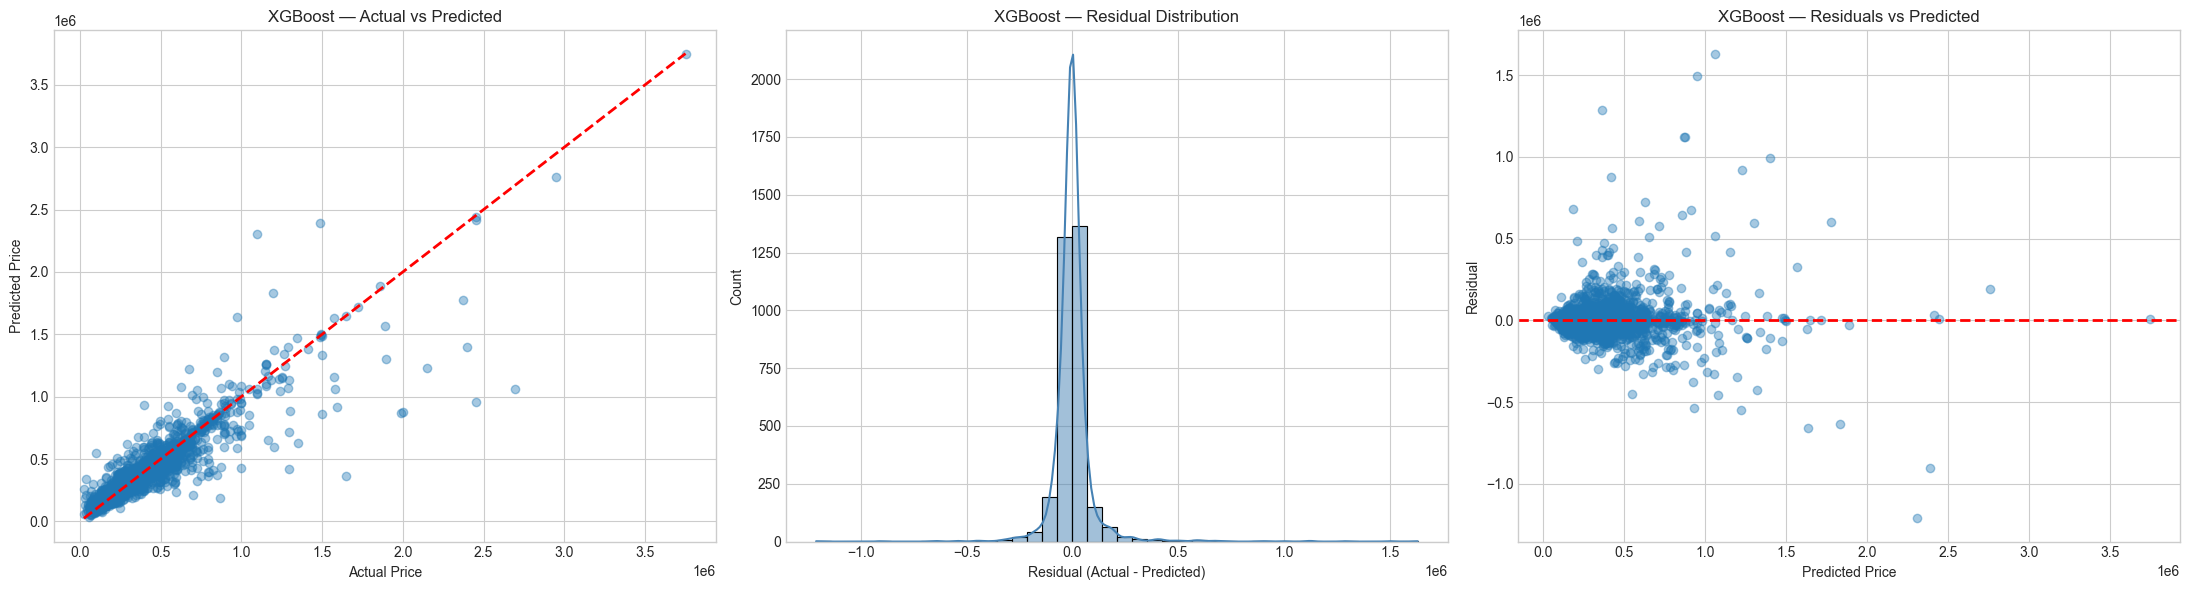

In [6]:
# ============================================================
# XGBOOST REGRESSOR — TRAIN / VAL / TEST
# ============================================================

from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Build X, y (tree-based → use model_type="rf")
X_train_xgb, y_train_xgb = prepare_X_y(df_train, model_type="rf")
X_val_xgb,   y_val_xgb   = prepare_X_y(df_val,   model_type="rf")
X_test_xgb,  y_test_xgb  = prepare_X_y(df_test,  model_type="rf")


# Pipeline: Imputer + XGBoost
xgb_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),  # optional: XGB handles NaNs
        ("model", XGBRegressor(
            n_estimators=400,
            learning_rate=0.05,
            max_depth=8,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            objective="reg:squarederror"
        ))
    ]
)

# Fit
xgb_pipeline.fit(X_train_xgb, y_train_xgb)

# Predict
y_pred_train_xgb = xgb_pipeline.predict(X_train_xgb)
y_pred_val_xgb   = xgb_pipeline.predict(X_val_xgb)
y_pred_test_xgb  = xgb_pipeline.predict(X_test_xgb)

# Evaluate
print("\n--- XGBoost (Train) ---")
evaluate_regression("XGBoost — Train", y_train_xgb, y_pred_train_xgb)

print("\n--- XGBoost (Validation) ---")
evaluate_regression("XGBoost — Validation", y_val_xgb, y_pred_val_xgb)

print("\n--- XGBoost (Test) ---")
evaluate_regression("XGBoost — Test", y_test_xgb, y_pred_test_xgb)

# Diagnostics on TEST
plot_regression_diagnostics(y_test_xgb, y_pred_test_xgb, title_prefix="XGBoost")


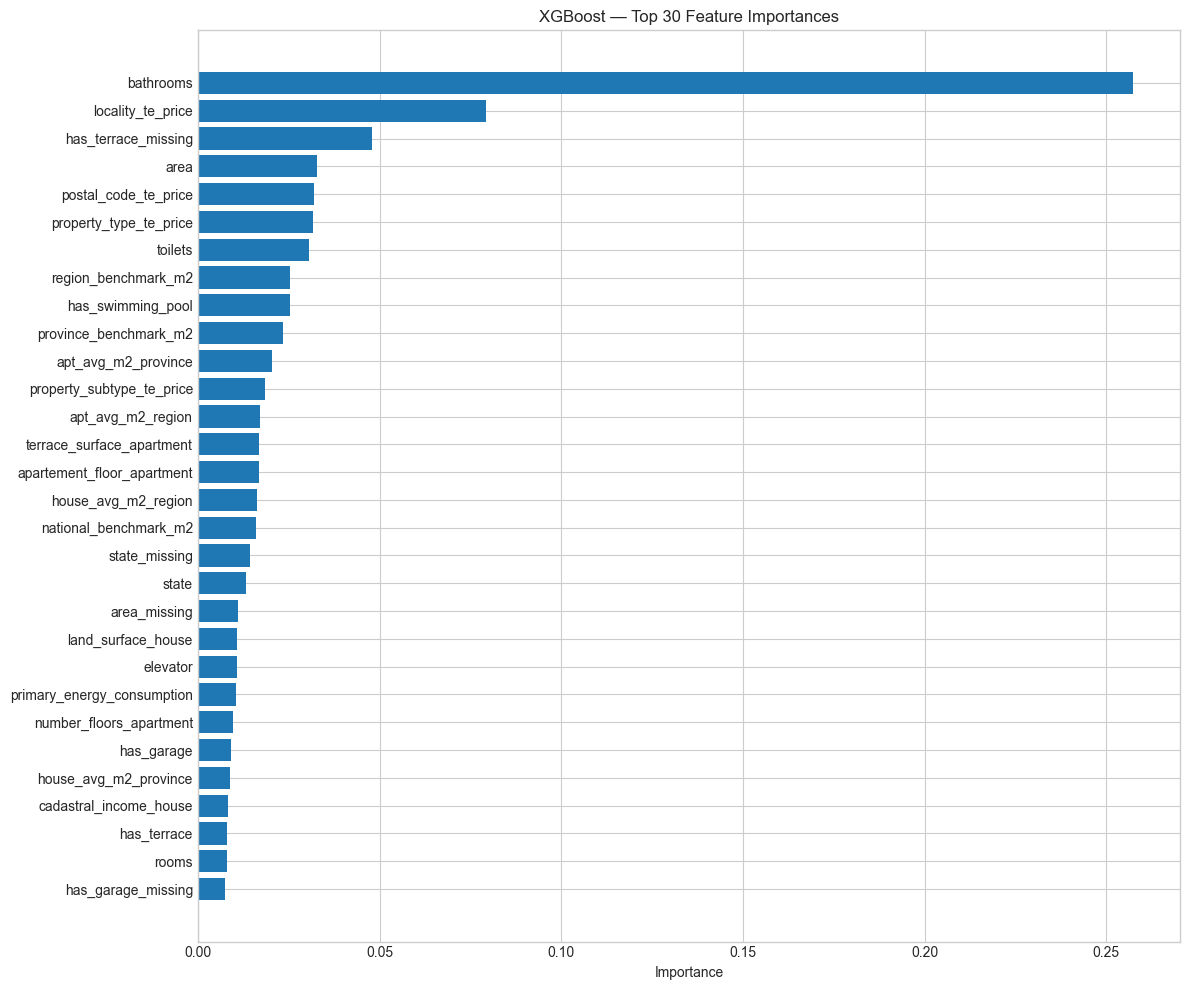

In [8]:
# ============================================================
# XGBOOST FEATURE IMPORTANCE
# ============================================================

xgb_model = xgb_pipeline.named_steps["model"]
importances = xgb_model.feature_importances_

plot_tree_importances(
    xgb_model,
    X_train_xgb.columns,
    top_n=30,
    title="XGBoost — Top 30 Feature Importances"
)


In [ ]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, mean_absolute_error

# ============================================================
# 0. Prepare data (from Stage2 → Stage3 split)
# ============================================================
X_train_xgb, y_train_xgb = prepare_X_y(df_train, model_type="rf")
X_val_xgb,   y_val_xgb   = prepare_X_y(df_val,   model_type="rf")
X_test_xgb,  y_test_xgb  = prepare_X_y(df_test,  model_type="rf")

# ============================================================
# 1. Build XGBoost tuning pipeline
# ============================================================
xgb_tune_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),  # XGB can handle NaN but keep consistent
        ("model", XGBRegressor(
            random_state=42,
            n_jobs=-1,
            objective="reg:squarederror",
            tree_method="hist"  # fastest option
        ))
    ]
)

# ============================================================
# 2. VERY light tuning grid (fast, meaningful)
# ============================================================
param_grid = {
    "model__n_estimators": [300, 400, 500],
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [6, 10],
    "model__subsample": [0.8],
    "model__colsample_bytree": [0.8]
}

# ============================================================
# 3. 3-Fold CV setup
# ============================================================
cv = KFold(n_splits=3, shuffle=True, random_state=42)

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

grid = GridSearchCV(
    estimator=xgb_tune_pipeline,
    param_grid=param_grid,
    scoring=mae_scorer,   # MAE for real estate stability
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# ============================================================
# 4. Run grid search — TRAIN ONLY (no leakage)
# ============================================================
print("\nRunning XGBoost tuning...")
grid.fit(X_train_xgb, y_train_xgb)

print("\nBest Hyperparameters:")
print(grid.best_params_)
print("Best CV MAE:", abs(grid.best_score_))

# ============================================================
# 5. Refit best model on full TRAIN
# ============================================================
best_xgb = grid.best_estimator_

# ============================================================
# 6. Predict on Train / Val / Test
# ============================================================
y_pred_train_xgb = best_xgb.predict(X_train_xgb)
y_pred_val_xgb   = best_xgb.predict(X_val_xgb)
y_pred_test_xgb  = best_xgb.predict(X_test_xgb)

# ============================================================
# 7. Evaluate
# ============================================================
print("\n--- XGBoost (Train, tuned) ---")
evaluate_regression("XGB — Train (tuned)", y_train_xgb, y_pred_train_xgb)

print("\n--- XGBoost (Validation, tuned) ---")
evaluate_regression("XGB — Validation (tuned)", y_val_xgb, y_pred_val_xgb)

print("\n--- XGBoost (Test, tuned) ---")
evaluate_regression("XGB — Test (tuned)", y_test_xgb, y_pred_test_xgb)

# Diagnostics
plot_regression_diagnostics(y_test_xgb, y_pred_test_xgb, title_prefix="XGB Tuned")


In [11]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import (
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
import numpy as np

# ============================================================
# 0. Rebuild your BEST XGBoost model
# ============================================================
best_xgb_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=10,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            objective="reg:squarederror",
            tree_method="hist"
        ))
    ]
)

# ============================================================
# 1. 5-Fold CV setup
# ============================================================
cv = KFold(n_splits=5, shuffle=True, random_state=4)

scoring = {
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "RMSE": make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), 
                        greater_is_better=False),
    "R2": make_scorer(r2_score)
}

# ============================================================
# 2. Run the 5-Fold CV
# ============================================================
cv_results = cross_validate(
    estimator=best_xgb_pipeline,
    X=X_train_xgb,
    y=y_train_xgb,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    verbose=2
)

# ============================================================
# 3. Print results
# ============================================================
print("\n========== 5-FOLD CROSS VALIDATION RESULTS (BEST XGBOOST) ==========\n")

for metric in ["MAE", "RMSE", "R2"]:
    mean_score = abs(cv_results[f"test_{metric}"]).mean() if metric != "R2" else cv_results[f"test_{metric}"].mean()
    std_score = abs(cv_results[f"test_{metric}"]).std() if metric != "R2" else cv_results[f"test_{metric}"].std()

    print(f"{metric}:  {mean_score:.4f} ± {std_score:.4f}")

print("\n====================================================================")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.



========== 5-FOLD CROSS VALIDATION RESULTS (BEST XGBOOST) ==========

MAE:  45739.9666 ± 1449.3156
RMSE:  105851.2624 ± 17826.0205
R2:  0.8351 ± 0.0374



[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   49.1s finished


## Full leakage test: Reverse test — Shuffle Target Test

In [12]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ============================================================
# 0. Your BEST XGBoost pipeline (unchanged)
# ============================================================
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

best_xgb_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=10,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            objective="reg:squarederror",
            tree_method="hist"
        ))
    ]
)

# ============================================================
# 1. SHUFFLE TARGET LEAKAGE TEST
# ============================================================
def leakage_shuffle_test(model, X_train, y_train, X_test, y_test):

    # ---- Step 1: Shuffle the target ----
    y_train_shuffled = shuffle(y_train, random_state=4)
    y_test_shuffled  = shuffle(y_test,  random_state=4)

    # ---- Step 2: Fit model on SHUFFLED target ----
    model.fit(X_train, y_train_shuffled)

    # ---- Step 3: Predictions ----
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    # ---- Step 4: Metrics ----
    train_r2  = r2_score(y_train_shuffled, y_pred_train)
    test_r2   = r2_score(y_test_shuffled,  y_pred_test)

    train_mae = mean_absolute_error(y_train_shuffled, y_pred_train)
    test_mae  = mean_absolute_error(y_test_shuffled,  y_pred_test)

    train_rmse = np.sqrt(mean_squared_error(y_train_shuffled, y_pred_train))
    test_rmse  = np.sqrt(mean_squared_error(y_test_shuffled,  y_pred_test))

    print("\n========== SHUFFLED TARGET — LEAKAGE TEST ==========")
    print("Train R²:      ", round(train_r2, 4))
    print("Train MAE:     ", round(train_mae, 2))
    print("Train RMSE:    ", round(train_rmse, 2))

    print("\nTest  R²:      ", round(test_r2, 4))
    print("Test  MAE:     ", round(test_mae, 2))
    print("Test  RMSE:    ", round(test_rmse, 2))

    print("====================================================\n")

# ============================================================
# 2. RUN THE TEST
# ============================================================
leakage_shuffle_test(
    best_xgb_pipeline,
    X_train_xgb,
    y_train_xgb,
    X_val_xgb,   # or X_test_xgb
    y_val_xgb
)



========== SHUFFLED TARGET — LEAKAGE TEST ==========
Train R²:       0.9087
Train MAE:      47064.38
Train RMSE:     78958.4

Test  R²:       -0.2728
Test  MAE:      182182.99
Test  RMSE:     314650.95



In [14]:
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Assume y_test_shuffled is your shuffled test target from the leakage test
y_test_shuffled = shuffle(y_test_xgb, random_state=42)

# Baseline: always predict mean of y_train_shuffled
baseline_pred = np.full_like(y_test_shuffled, fill_value=y_train_xgb.mean(), dtype=float)

print("Baseline MAE:", mean_absolute_error(y_test_shuffled, baseline_pred))
print("Baseline R² :", r2_score(y_test_shuffled, baseline_pred))


Baseline MAE: 153181.0121157664
Baseline R² : -4.7429448527980256e-05


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# 1. Extract trained XGBoost model from pipeline
# ============================================================
xgb_model = best_xgb_pipeline.named_steps["model"]

# ============================================================
# 2. Get feature importances (Gain-based)
# ============================================================
importances = xgb_model.get_booster().get_score(importance_type="gain")

# Convert dict → DataFrame
importance_df = (
    pd.DataFrame([
        {"feature": k, "gain": v} 
        for k, v in importances.items()
    ])
    .sort_values("gain", ascending=False)
)

print("Top 30 Features (by Gain):")
display(importance_df.head(30))

# ============================================================
# 3. Match back to your actual feature names
# ============================================================
# NOTE: XGBoost uses f0, f1, f2... so map them:
feature_map = {
    f"f{i}": col for i, col in enumerate(X_train_xgb.columns)
}

importance_df["real_feature"] = importance_df["feature"].map(feature_map)

print("\nTop 30 Features with Real Names:")
display(importance_df[["real_feature", "gain"]].head(30))

# ============================================================
# 4. PLOT (Top 20)
# ============================================================
topk = 20
plot_df = importance_df.head(topk).copy()
plot_df["real_feature"] = plot_df["real_feature"].astype(str)

plt.figure(figsize=(10, 10))
plt.barh(plot_df["real_feature"][::-1], plot_df["gain"][::-1])
plt.title("XGBoost Feature Importance (Gain) — Top 20")
plt.xlabel("Gain")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# 1. Fit your tuned model (if not already fitted)
# ============================================================
best_xgb_pipeline.fit(X_train_xgb, y_train_xgb)

# Extract trained XGB model
xgb_model = best_xgb_pipeline.named_steps["model"]

# ============================================================
# 2. Prepare a sample for SHAP (faster, avoids memory overload)
# ============================================================
sample_size = min(5000, X_train_xgb.shape[0])  # cap at 5000 rows
X_sample = X_train_xgb.sample(sample_size, random_state=42)

# ============================================================
# 3. Create SHAP Explainer
# ============================================================
explainer = shap.TreeExplainer(xgb_model)

print("Computing SHAP values… (this may take a few seconds)")
shap_values = explainer.shap_values(X_sample)

# ============================================================
# 4. SHAP Summary Plot (global feature importance)
# ============================================================
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, plot_type="dot", show=True)

# ============================================================
# 5. SHAP Feature Importance Bar Plot
# ============================================================
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=True)

# ============================================================
# 6. (Optional) Get mean absolute SHAP per feature in a DF
# ============================================================
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({
    "feature": X_train_xgb.columns,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

print("\nTop 20 Features by Mean |SHAP|:")
display(shap_df.head(20))


In [ ]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import (
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
import numpy as np

# ============================================================
# 0. Rebuild your BEST XGBoost model
# ============================================================
best_xgb_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=10,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            objective="reg:squarederror",
            tree_method="hist"
        ))
    ]
)

# ============================================================
# 1. 5-Fold CV setup
# ============================================================
cv = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "RMSE": make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)),
                        greater_is_better=False),
    "R2": make_scorer(r2_score)
}

# ============================================================
# 2. Run the 5-Fold CV (TRAIN ONLY)
# ============================================================
cv_results = cross_validate(
    estimator=best_xgb_pipeline,
    X=X_train_xgb,
    y=y_train_xgb,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    verbose=2
)

print("\n========== 5-FOLD CROSS VALIDATION RESULTS ==========\n")

for metric in ["MAE", "RMSE", "R2"]:
    scores = cv_results[f"test_{metric}"]
    # MAE & RMSE negative because of scorer → take abs for readability
    if metric in ["MAE", "RMSE"]:
        mean_score = abs(scores.mean())
        std_score = abs(scores.std())
    else:
        mean_score = scores.mean()
        std_score = scores.std()
    print(f"{metric}:  {mean_score:.4f} ± {std_score:.4f}")

print("\n=====================================================\n")

# ============================================================
# 3. Refit the model on full TRAIN
# ============================================================
best_xgb_pipeline.fit(X_train_xgb, y_train_xgb)

# ============================================================
# 4. Evaluate on TRAIN and VALIDATION
# ============================================================
y_pred_train = best_xgb_pipeline.predict(X_train_xgb)
y_pred_val   = best_xgb_pipeline.predict(X_val_xgb)

print("\n========== TRAIN PERFORMANCE (BEST XGBoost) ==========\n")
evaluate_regression("XGB — Train", y_train_xgb, y_pred_train)

print("\n========== VALIDATION PERFORMANCE (BEST XGBoost) ==========\n")
evaluate_regression("XGB — Validation", y_val_xgb, y_pred_val)


Shapes (CatBoost):
X_train: (15030, 72)  y_train: (15030,)
X_val  : (3221, 72)  y_val  : (3221,)
X_test : (3221, 72)  y_test : (3221,)

--- CatBoost (Train) ---
===== CatBoost — Train =====
MAE: 31,205.85
R² : 0.9697

--- CatBoost (Validation) ---
===== CatBoost — Validation =====
MAE: 50,913.13
R² : 0.8762

--- CatBoost (Test) ---
===== CatBoost — Test =====
MAE: 51,919.58
R² : 0.8132


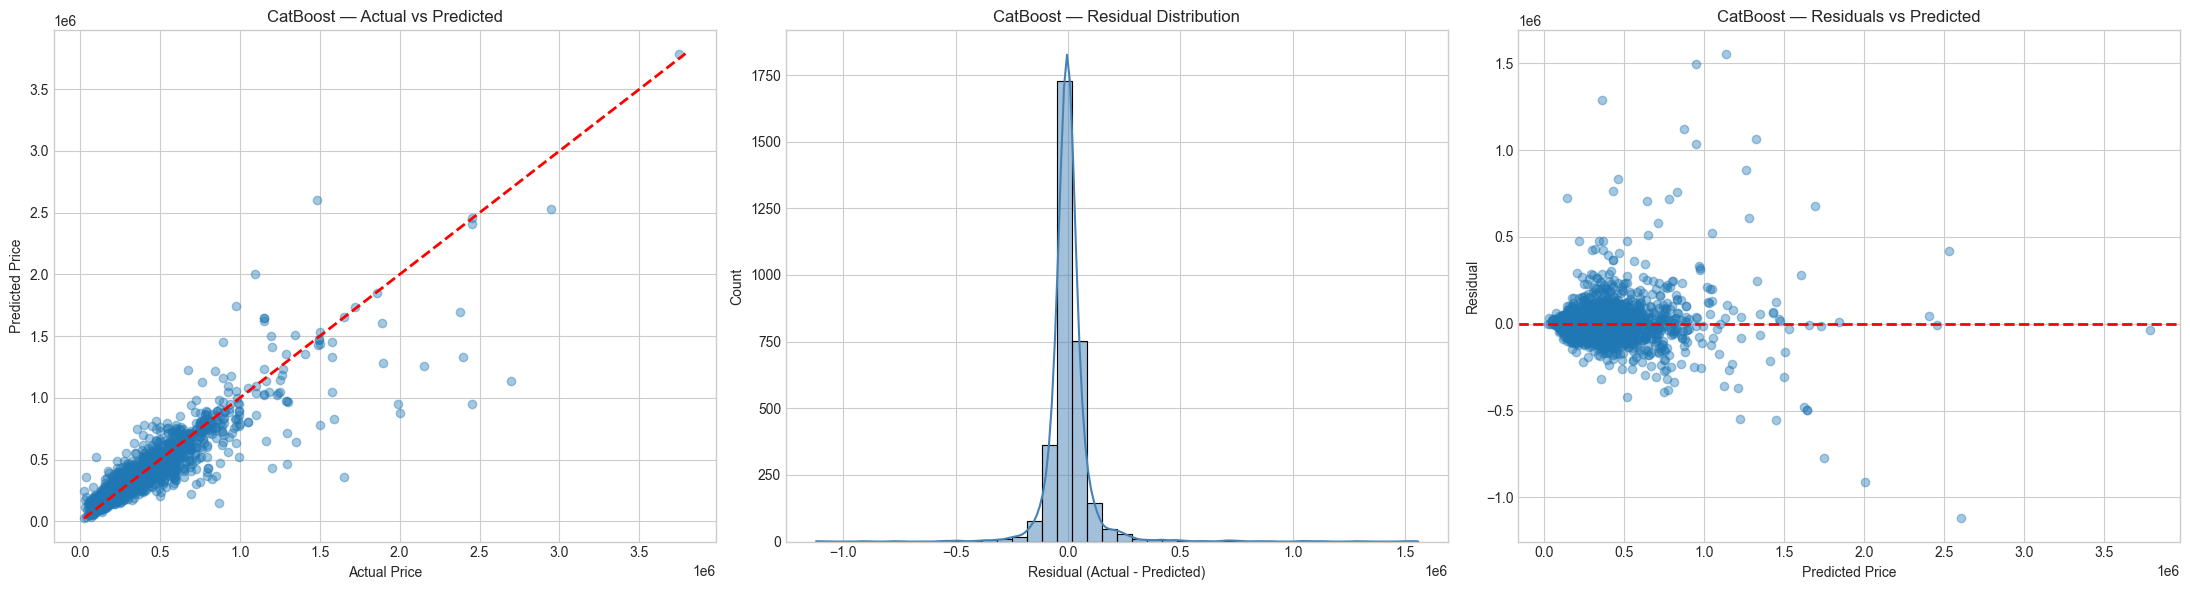

In [16]:
# ============================================================
# CATBOOST REGRESSOR — TRAIN / VAL / TEST
# ============================================================

from catboost import CatBoostRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Build X, y (tree-based → model_type="rf")
X_train_cat, y_train_cat = prepare_X_y(df_train, model_type="rf")
X_val_cat,   y_val_cat   = prepare_X_y(df_val,   model_type="rf")
X_test_cat,  y_test_cat  = prepare_X_y(df_test,  model_type="rf")

print("Shapes (CatBoost):")
print("X_train:", X_train_cat.shape, " y_train:", y_train_cat.shape)
print("X_val  :", X_val_cat.shape,   " y_val  :", y_val_cat.shape)
print("X_test :", X_test_cat.shape,  " y_test :", y_test_cat.shape)

# Pipeline: Imputer + CatBoost
cat_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", CatBoostRegressor(
            iterations=1000,
            learning_rate=0.05,
            depth=8,
            loss_function="RMSE",
            random_seed=42,
            verbose=False
        ))
    ]
)

# Fit
cat_pipeline.fit(X_train_cat, y_train_cat)

# Predict
y_pred_train_cat = cat_pipeline.predict(X_train_cat)
y_pred_val_cat   = cat_pipeline.predict(X_val_cat)
y_pred_test_cat  = cat_pipeline.predict(X_test_cat)

# Evaluate
print("\n--- CatBoost (Train) ---")
evaluate_regression("CatBoost — Train", y_train_cat, y_pred_train_cat)

print("\n--- CatBoost (Validation) ---")
evaluate_regression("CatBoost — Validation", y_val_cat, y_pred_val_cat)

print("\n--- CatBoost (Test) ---")
evaluate_regression("CatBoost — Test", y_test_cat, y_pred_test_cat)

# Diagnostics (on TEST)
plot_regression_diagnostics(y_test_cat, y_pred_test_cat, title_prefix="CatBoost")


In [ ]:
cat_model = cat_pipeline.named_steps["model"]

plot_tree_importances(
    cat_model,
    X_train_cat.columns,
    top_n=30,
    title="CatBoost — Top 30 Feature Importances"
)
